In [ ]:
!pip install pydub
!pip install librosa


In [ ]:
from pydub import AudioSegment
import librosa
import matplotlib.pyplot as plt
import numpy as np


def load_split_sample(audio_path,idx=0):
  # Load the audio file
  audio = AudioSegment.from_file(audio_path)
  # Resample to 1000 Hz
  audio_1000Hz = audio.set_frame_rate(1000)
  # Resample to 8000 Hz
  audio_8000Hz = audio.set_frame_rate(8000)
  # Save the resampled audio files
  audio_1000Hz.export(f"audio_{idx}_1000Hz.wav", format="wav")
  audio_8000Hz.export(f"audio_{idx}_8000Hz.wav", format="wav")
  print("Audio resampled and saved successfully.")
  x_raw = audio.split_to_mono()
  x_8k=audio_8000Hz.split_to_mono()
  x_1k=audio_1000Hz.split_to_mono()
  return x_raw,x_8k,x_1k

def print_spectrogram(audio):
  y=np.array(audio[0].get_array_of_samples(),dtype=np.float)
  window_size = int(0.06*8000)
  overlap = int(0.01*8000)
  D = librosa.stft(y, n_fft=window_size, hop_length=overlap)

  # Convert to decibels (dB)
  D_db = librosa.amplitude_to_db(abs(D), ref=np.max)

  # Plot the spectrogram
  plt.figure(figsize=(10, 6))
  librosa.display.specshow(D_db, sr=8000, hop_length=overlap, x_axis='time', y_axis='hz')
  plt.colorbar(format="%+2.0f dB")
  plt.title("Spectrogram")
  plt.xlabel("Time (s)")
  plt.ylabel("Frequency (Hz)")
  plt.tight_layout()
  plt.show()

### For Member 1

Audio resampled and saved successfully.


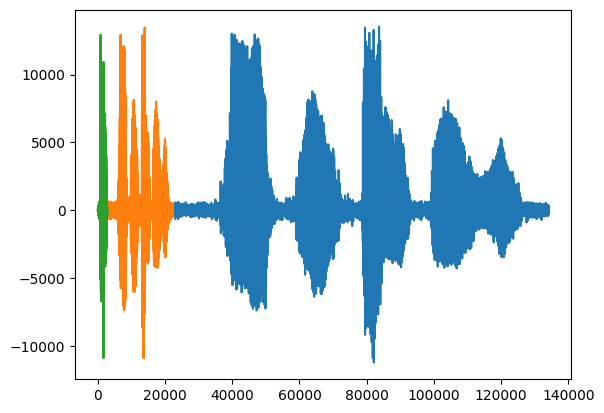

In [ ]:
x_raw,x_8k,x_1k = load_split_sample("/content/audio.mp4",)
#Visualize
plt.plot(x_raw[0].get_array_of_samples())
plt.plot(x_8k[0].get_array_of_samples())
plt.plot(x_1k[0].get_array_of_samples())


<ipython-input-145-311d0b774ded>:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=np.array(audio[0].get_array_of_samples(),dtype=np.float)


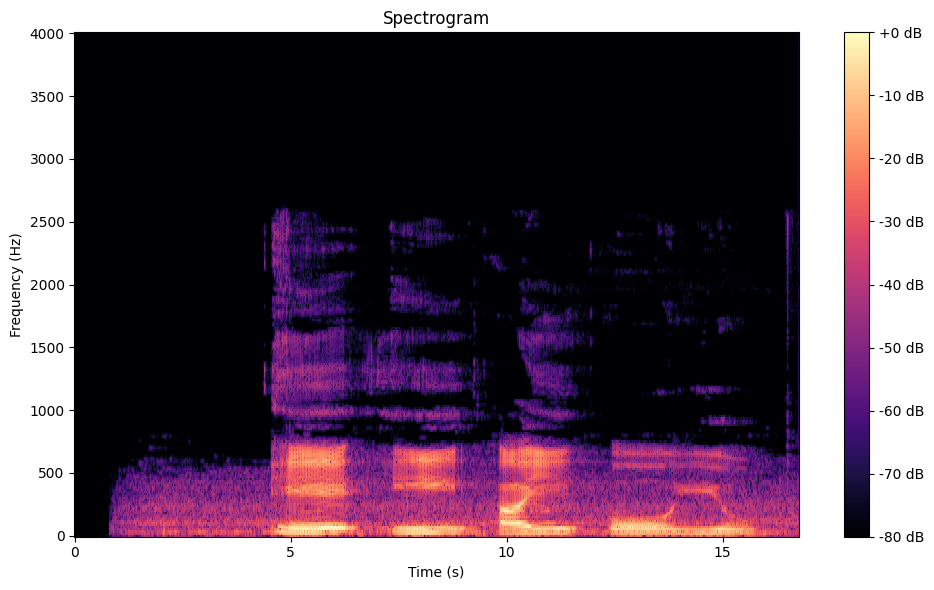

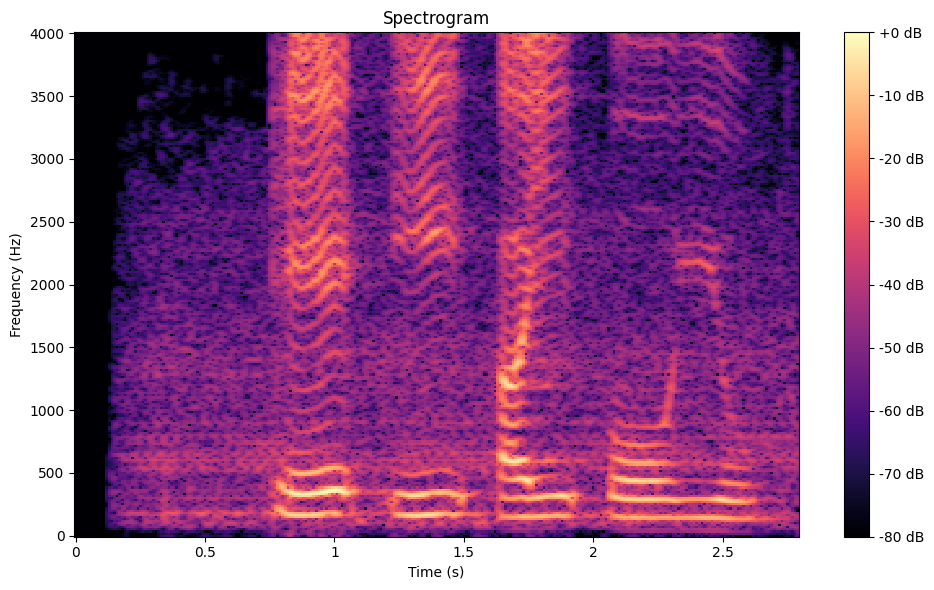

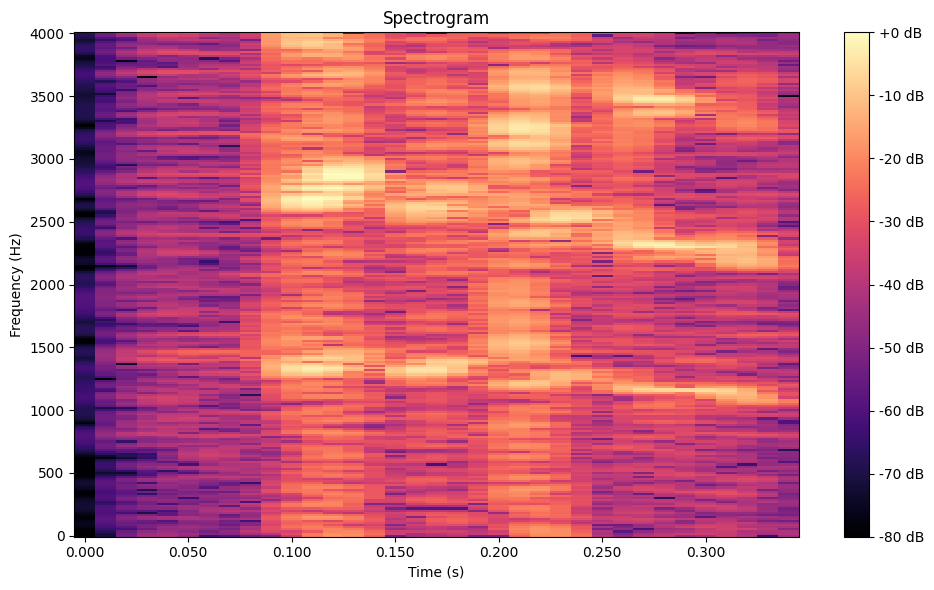

In [ ]:
print_spectrogram(x_raw)
print_spectrogram(x_8k)
print_spectrogram(x_1k)



### For Member2

Audio resampled and saved successfully.


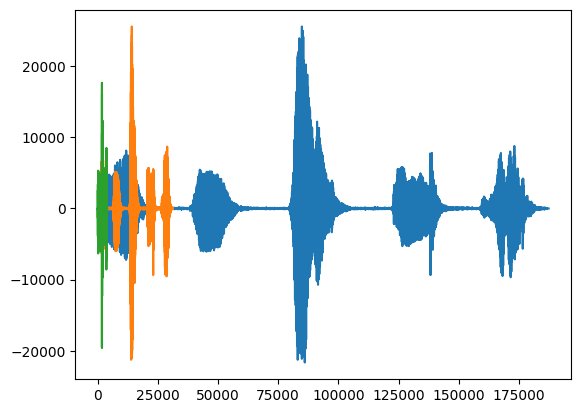

In [ ]:
x_raw_1,x_8k_1,x_1k_1 = load_split_sample("/content/audio_1.mp4",1)
#Visualize
plt.plot(x_raw_1[0].get_array_of_samples())
plt.plot(x_8k_1[0].get_array_of_samples())
plt.plot(x_1k_1[0].get_array_of_samples())


<ipython-input-145-311d0b774ded>:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=np.array(audio[0].get_array_of_samples(),dtype=np.float)


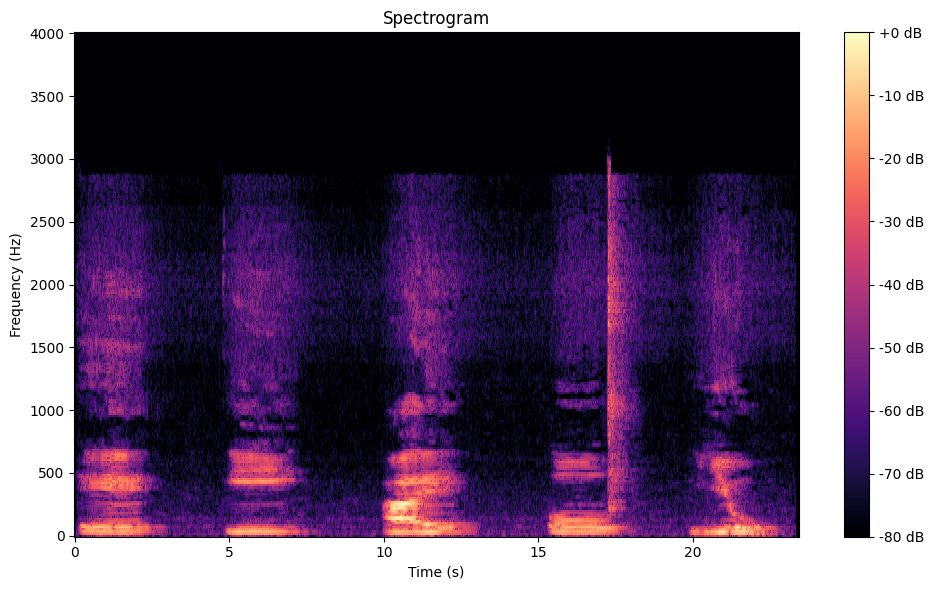

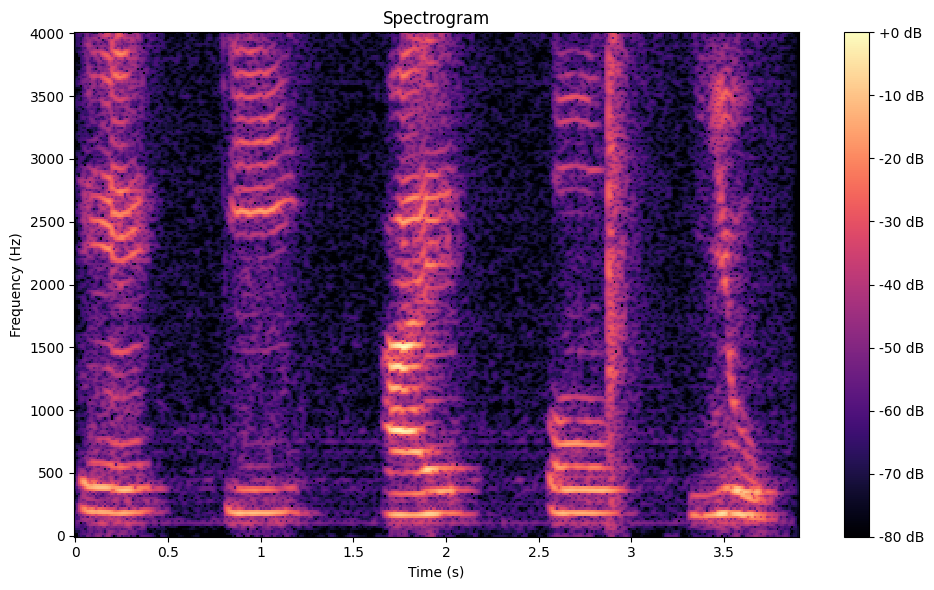

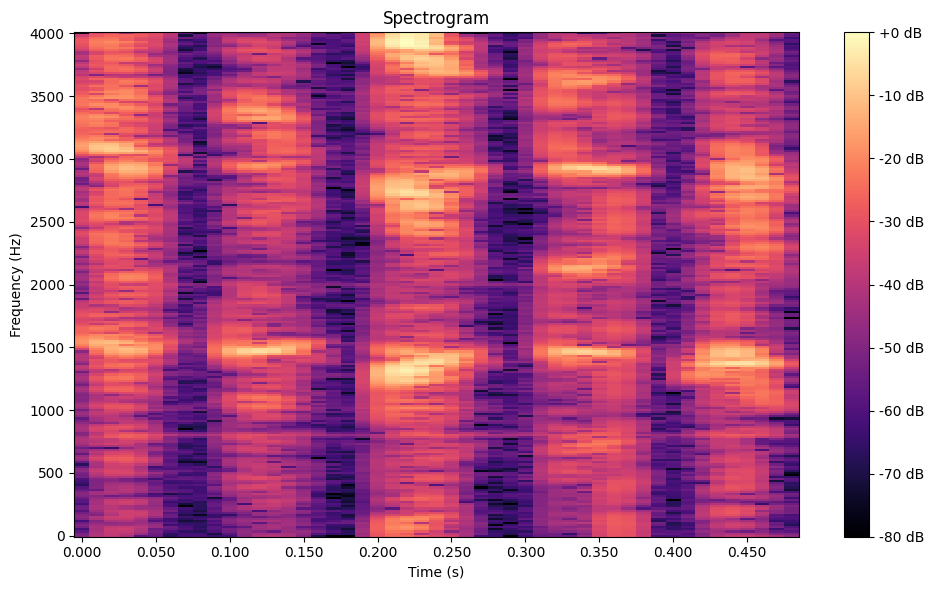

In [ ]:
print_spectrogram(x_raw_1)
print_spectrogram(x_8k_1)
print_spectrogram(x_1k_1)



# Question 2

## AutoCorrelation Method

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
torch.manual_seed(1)
import librosa.display, librosa
import scipy


In [ ]:
def Autocor(signal, k):

    if k == 0:
        return np.sum(signal**2)
    else:
        return np.sum(signal[k:]*signal[:-k])

In [ ]:
from scipy.linalg import solve_toeplitz, toeplitz

def Levinson(w_sig,p):
    r_list = [Autocor(w_sig,i) for i in range(p)]
    b_list = [Autocor(w_sig,i) for i in range(1,p+1)]
    LPC = solve_toeplitz((r_list,r_list),b_list)
    return LPC

In [ ]:
'''Get prediction, residual signal'''
def residual(windowed_signal, p,LPC=None):
    if LPC is None:
      LPC = Levinson(windowed_signal,p)
    length = len(windowed_signal)
    prediction = np.zeros((length))
    win_sig = np.pad(windowed_signal, p)[:-p]
    for k in range(length):
        prediction[k] = np.sum(win_sig[k:k+p][::-1]*LPC)
    error = windowed_signal - prediction
    return prediction, error

In [ ]:
'''Get prediction, residual error for whole signal'''
def prediction(signal, window, p, overlap = 0.5):

    '''padding'''
    shift = int(len(window)*overlap)
    if len(signal) % shift != 0:
        pad = np.zeros(shift - (len(signal) % shift))
        new_signal = np.append(signal, pad)
    else:
        new_signal = signal
    index = (len(new_signal) // shift) -1

    '''make array'''
    whole_prediction = np.zeros((len(new_signal)),dtype = np.float128)
    whole_error = np.zeros((len(new_signal)),dtype = np.float128)
    for i in range(index):
        win_sig = new_signal[i*shift:i*shift+len(window)]*window #windowing

        prediction, error = residual(win_sig, p)
        whole_prediction[i*shift:i*shift+len(window)] += prediction
        whole_error[i*shift:i*shift+len(window)] += error

    return whole_prediction, whole_error


In [ ]:
window = np.hamming(8000*0.06)
signal=np.array(x_raw[0].get_array_of_samples(),dtype=np.float32)[6070:]
signal1=np.array(x_8k[0].get_array_of_samples(),dtype=np.float32)[6070//6:]
signal2=np.array(x_1k[0].get_array_of_samples(),dtype=np.float32)[6070//48:]

pred,err = prediction(signal1, window, 6)
pred_1,err_1 = prediction(signal1, window, 8)
pred_2,err_2 = prediction(signal1, window, 12)
pred_3,err_3 = prediction(signal1, window, 16)


In [ ]:
def plot_PE(signal, whole_pred, whole_error,sr, start, end, error = False):

    whole_pred = whole_pred[:len(signal)]
    whole_error = whole_error[:len(signal)]
    t_axis = np.arange(len(signal))/sr

    # plt.figure(figsize=(10,3))
    # plt.grid(True)
    plt.xlabel('Time(sec)')
    plt.ylabel('Amplitude')
    plt.xlim(start, end)

    if not error:
        plt.plot(t_axis, signal)
        plt.plot(t_axis, whole_pred, '--')
        plt.legend(['original','prediction'])
        plt.title('Original signal & Prediction')
    else:
        plt.plot(t_axis, whole_error)
        plt.title('Residual Error')

    plt.show()

### For Member 1

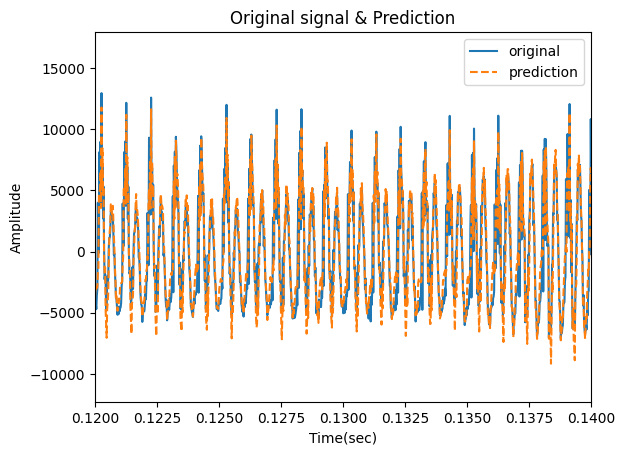

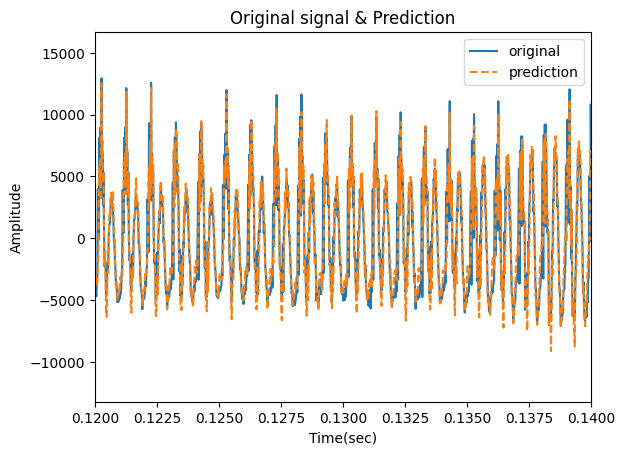

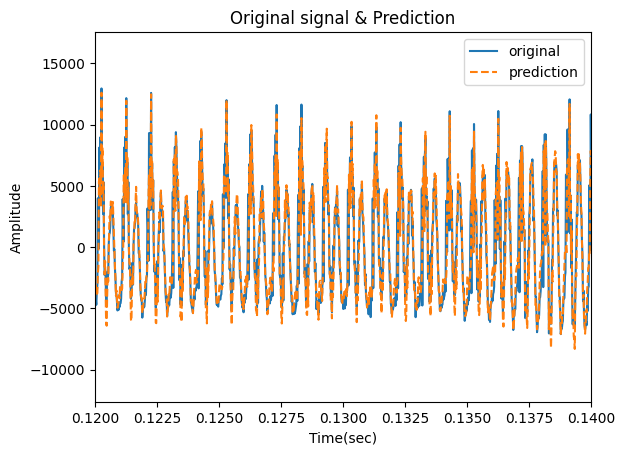

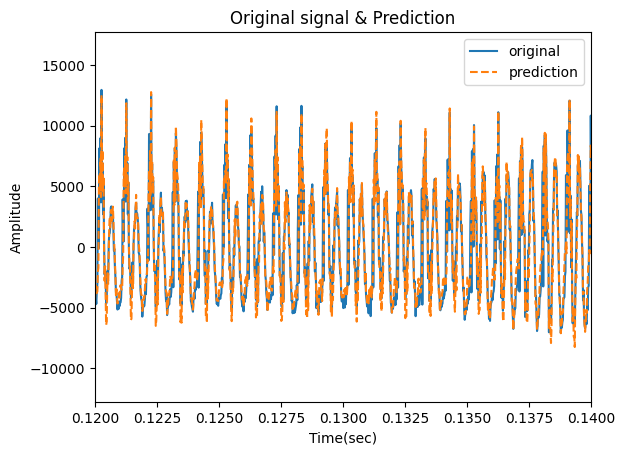

In [ ]:
plot_PE(signal1, pred, err, 48000, 0.12,0.14, False)
plot_PE(signal1, pred_1, err_1, 48000, 0.12,0.14, False)
plot_PE(signal1, pred_2, err_2, 48000, 0.12,0.14, False)
plot_PE(signal1, pred_3, err_3, 48000, 0.12,0.14, False)

### For Member2

In [ ]:
window = np.hamming(8000*0.06)

signal1_1=np.array(x_8k_1[0].get_array_of_samples(),dtype=np.float32)


pred,err = prediction(signal1_1, window, 6)
pred_1,err_1 = prediction(signal1_1, window, 8)
pred_2,err_2 = prediction(signal1_1, window, 12)
pred_3,err_3 = prediction(signal1_1, window, 16)


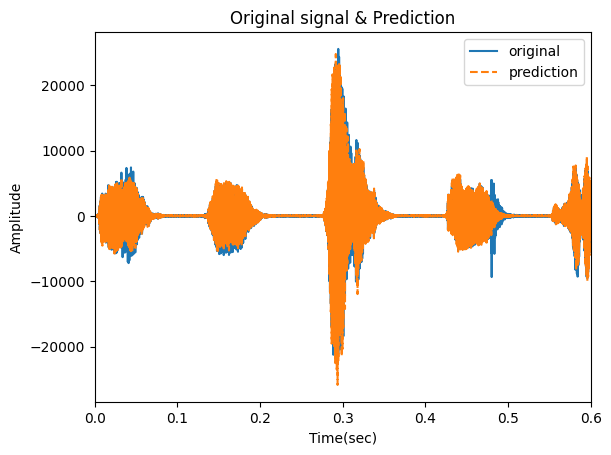

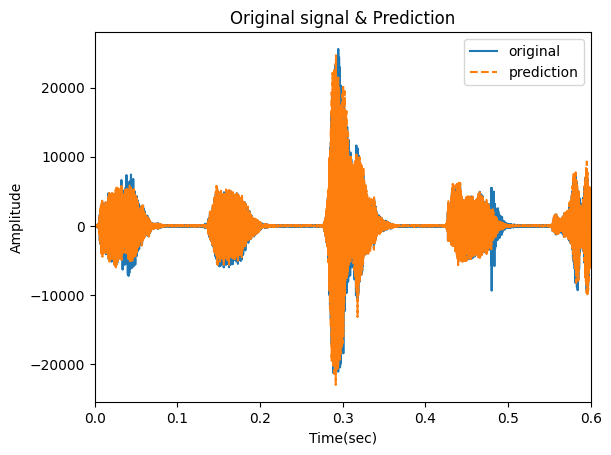

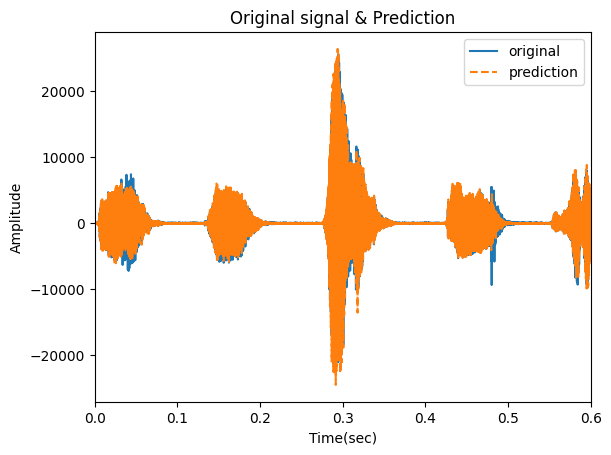

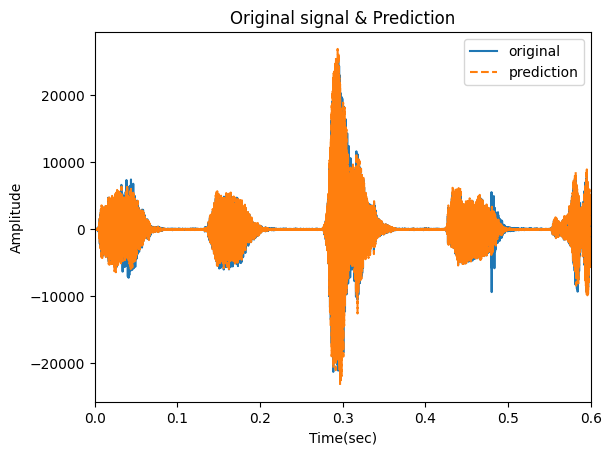

In [ ]:
plot_PE(signal1_1, pred, err, 48000, 0,0.6, False)
plot_PE(signal1_1, pred_1, err_1, 48000, 0,0.6, False)
plot_PE(signal1_1, pred_2, err_2, 48000, 0,0.6, False)
plot_PE(signal1_1, pred_3, err_3, 48000, 0,0.6, False)

## Covariance method

In [ ]:
def covariance_lpc(signal, order):
    # Calculate the covariance matrix
    N = len(signal)
    cov_matrix = np.zeros((order, order))

    for i in range(order):
        for j in range(order):
            cov_matrix[i, j] = np.sum(signal[i:N-j] * signal[i+j:N])

    # Calculate the autocorrelation vector
    r = np.zeros(order)
    for i in range(order):
        r[i] = np.sum(signal[i:N] * signal[:N-i])

    # Solve for LPC coefficients
    A = np.linalg.solve(cov_matrix, r)

    return A

In [ ]:
def residual_Cov(windowed_signal, p,LPC=None):
    if LPC is None:
      LPC = covariance_lpc(windowed_signal,p)
    length = len(windowed_signal)
    prediction = np.zeros((length))
    win_sig = np.pad(windowed_signal, p)[:-p]
    for k in range(length):
        prediction[k] = np.sum(win_sig[k:k+p][::-1]*LPC)
    error = windowed_signal - prediction
    return prediction, error

In [ ]:
'''Get prediction, residual error for whole signal'''
def prediction_Cov(signal, window, p, overlap = 0.5):

    '''padding'''
    shift = int(len(window)*overlap)
    if len(signal) % shift != 0:
        pad = np.zeros(shift - (len(signal) % shift))
        new_signal = np.append(signal, pad)
    else:
        new_signal = signal
    index = (len(new_signal) // shift) -1

    '''make array'''
    whole_prediction = np.zeros((len(new_signal)),dtype = np.float128)
    whole_error = np.zeros((len(new_signal)),dtype = np.float128)
    for i in range(index):
        win_sig = new_signal[i*shift:i*shift+len(window)]*window #windowing

        prediction, error = residual_Cov(win_sig, p)
        whole_prediction[i*shift:i*shift+len(window)] += prediction
        whole_error[i*shift:i*shift+len(window)] += error

    return whole_prediction, whole_error

In [ ]:
pred,err = prediction_Cov(signal1, window, 32)

In [ ]:
def plot_PE(signal, whole_pred, whole_error,sr, start, end, error = False):

    whole_pred = whole_pred[:len(signal)]
    whole_error = whole_error[:len(signal)]
    t_axis = np.arange(len(signal))/sr

    # plt.figure(figsize=(10,3))
    # plt.grid(True)
    plt.xlabel('Time(sec)')
    plt.ylabel('Amplitude')
    plt.xlim(start, end)

    if not error:
        plt.plot(t_axis, signal)
        plt.plot(t_axis, whole_pred, '--')
        plt.legend(['original','prediction'])
        plt.title('Original signal & Prediction')
    else:
        plt.plot(t_axis, whole_error)
        plt.title('Residual Error')

    plt.show()

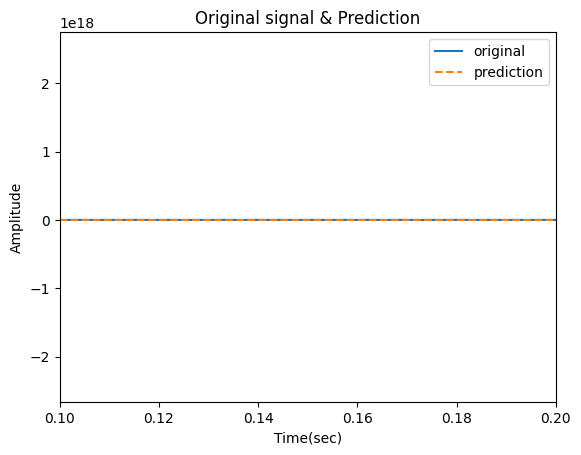

In [ ]:
plot_PE(pred, pred, err, 48000, 0.1,0.2, False)

# Question 3

### Member 1

<ipython-input-171-f21abe5b4e45>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


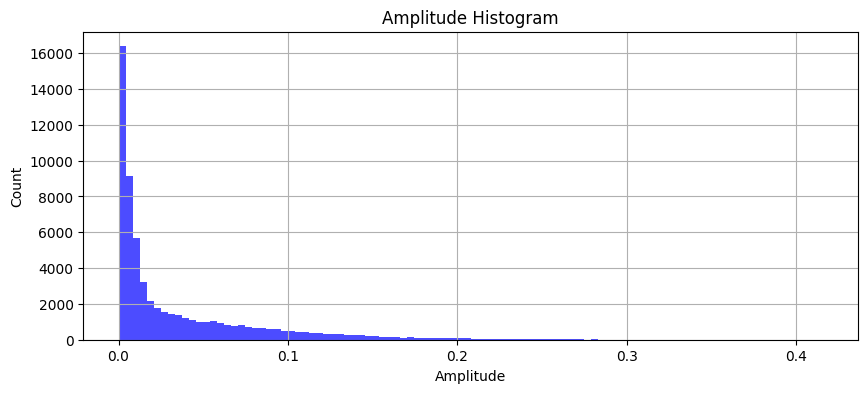

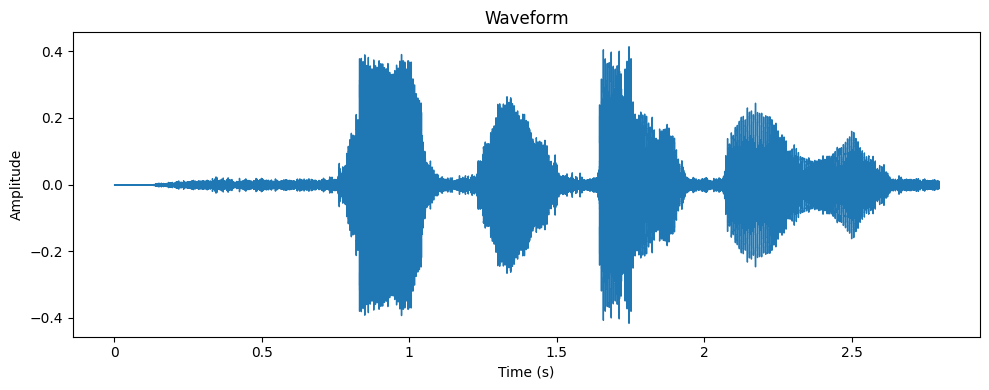

In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

def plot_amplitude_histogram(y, title):
    plt.figure(figsize=(10, 4))
    plt.hist(y, bins=100, color='blue', alpha=0.7)
    plt.xlabel('Amplitude')
    plt.ylabel('Count')
    plt.title(title)
    plt.grid()
    plt.show()

# Load the audio file
audio_path = '/content/audio.mp4'
y, sr = librosa.load(audio_path)

# Calculate amplitude
amplitudes = np.abs(y)

# Plot the histogram of amplitudes
plot_amplitude_histogram(amplitudes, 'Amplitude Histogram')

# Display the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.tight_layout()
plt.show()


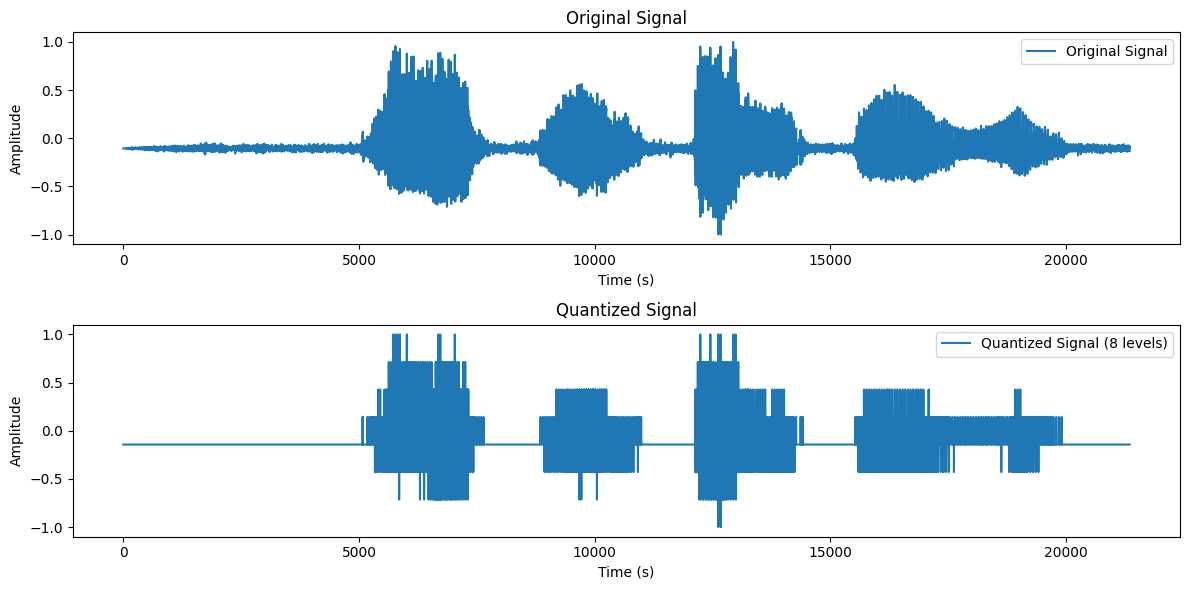

In [ ]:
# in place of x I need to put the given signal. -->> Uniform Quantiser
import numpy as np
import matplotlib.pyplot as plt

num_levels=8
# Generate the input signal (e.g., a sine wave)
duration = 1.0  # seconds
sampling_rate = 1000  # Hz
t = np.linspace(0, duration, int(duration * sampling_rate), endpoint=False)
x = signal1  # Example: sine wave
# Normalize the input signal to the range [-1, 1]
x_normalized = (x - np.min(x)) / (np.max(x) - np.min(x)) * 2 - 1

# Quantize the normalized signal
quantized_signal = np.round((x_normalized + 1) * (num_levels - 1) / 2) * 2 / (num_levels - 1) - 1

# Plot the original and quantized signals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot( x_normalized, label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot( quantized_signal, label=f'Quantized Signal ({num_levels} levels)')
plt.title('Quantized Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()


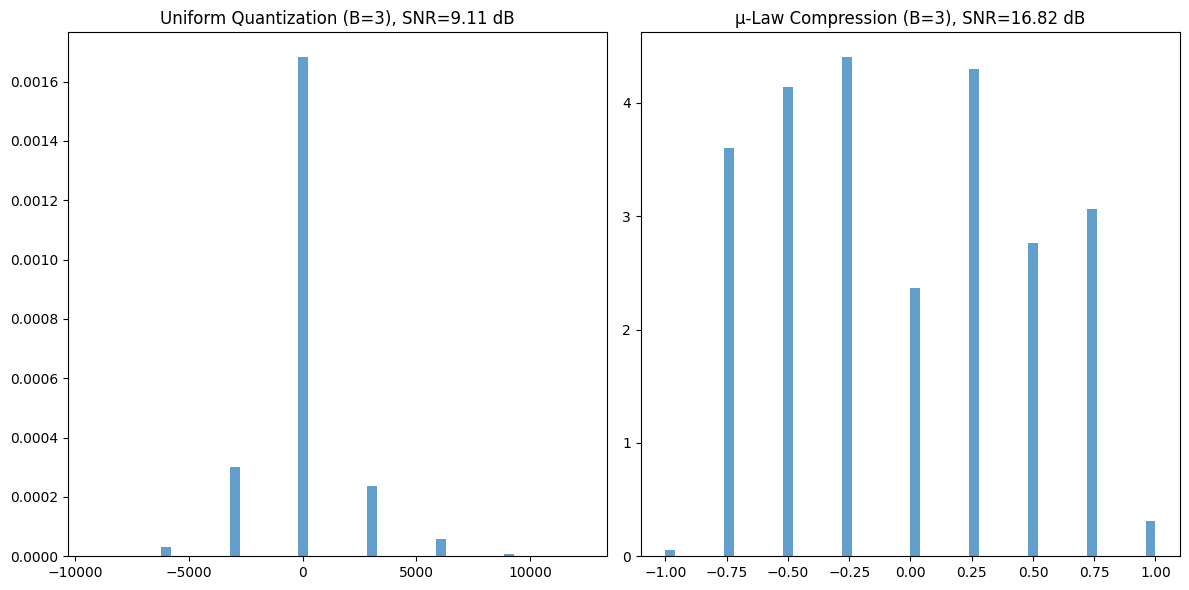

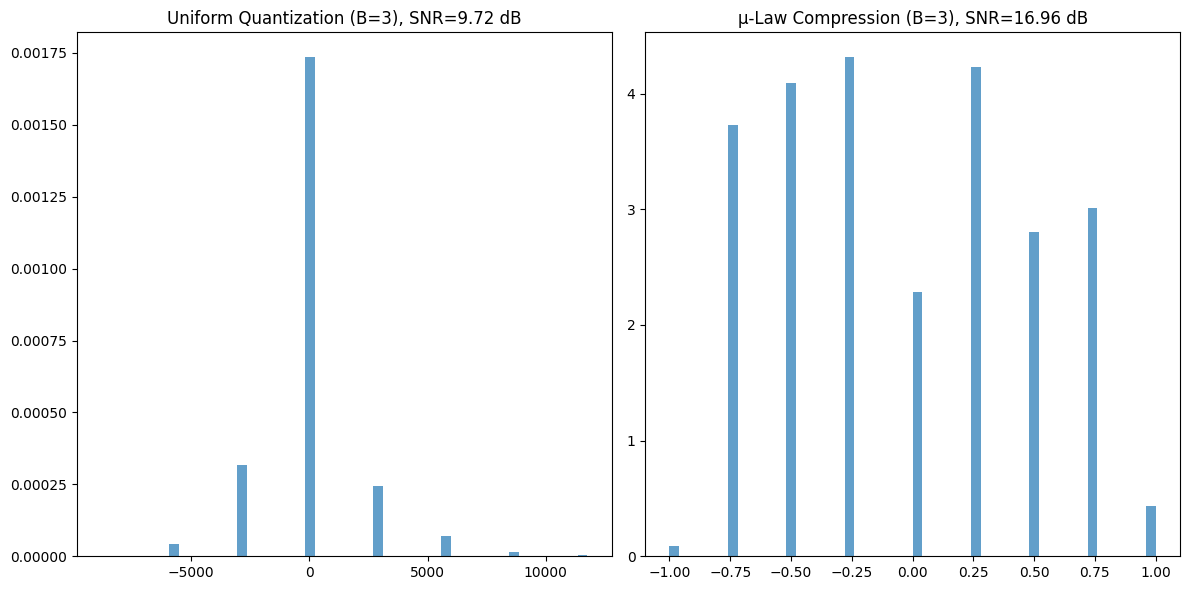

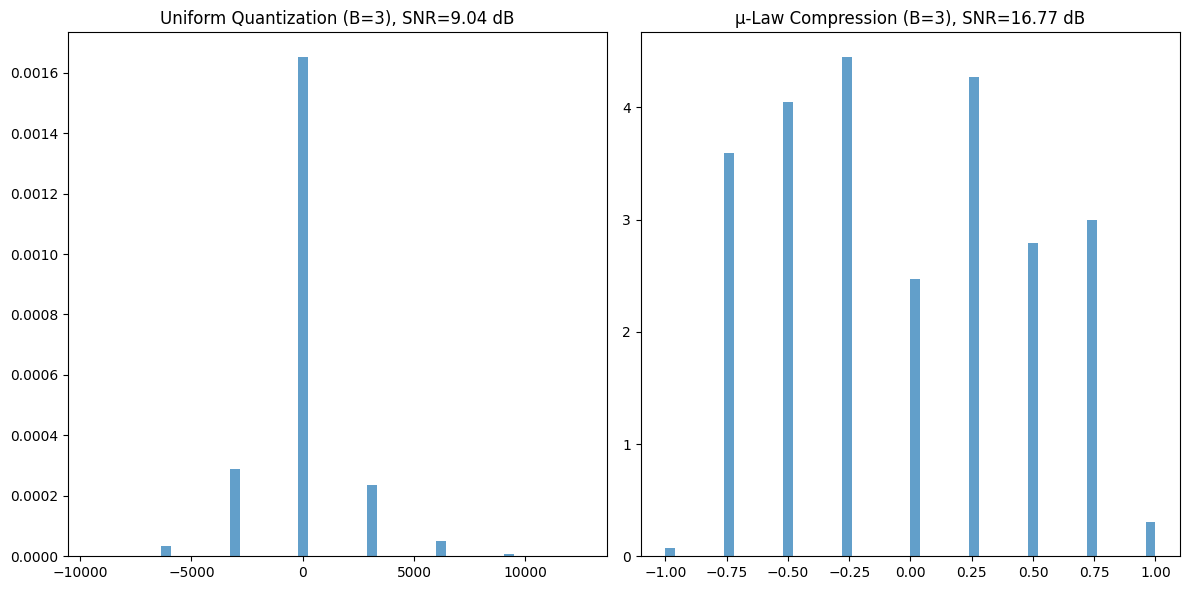

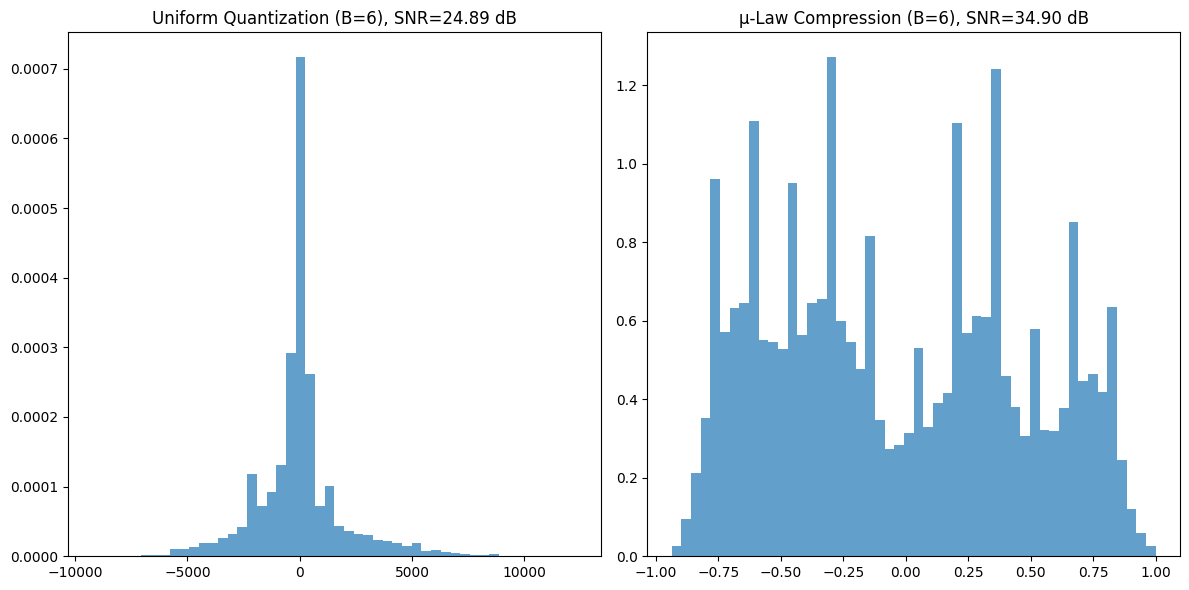

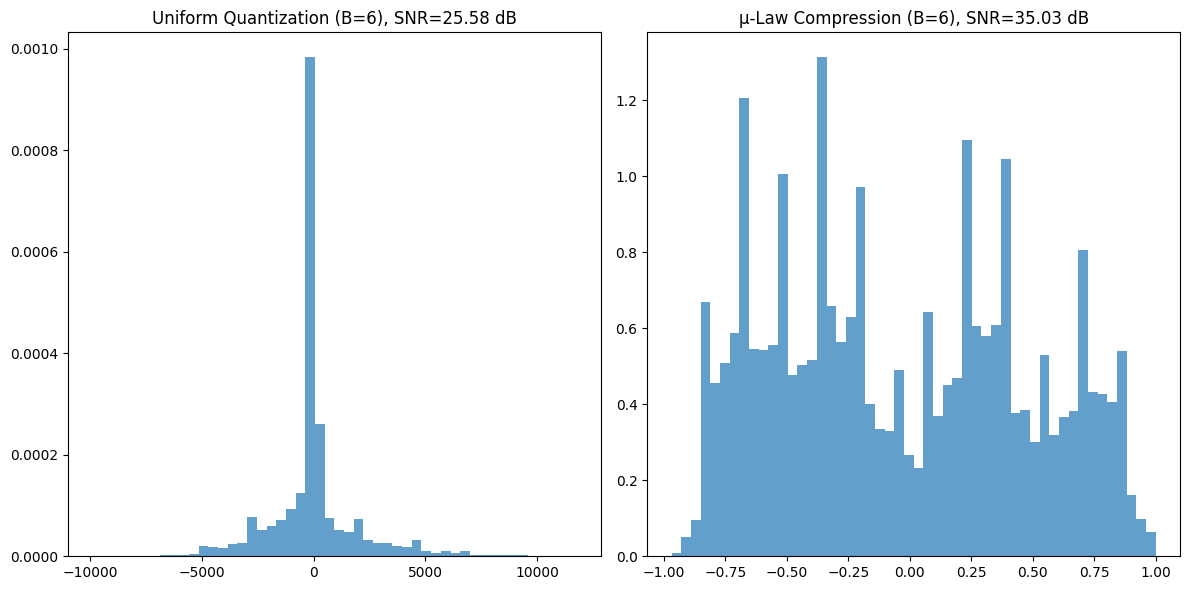

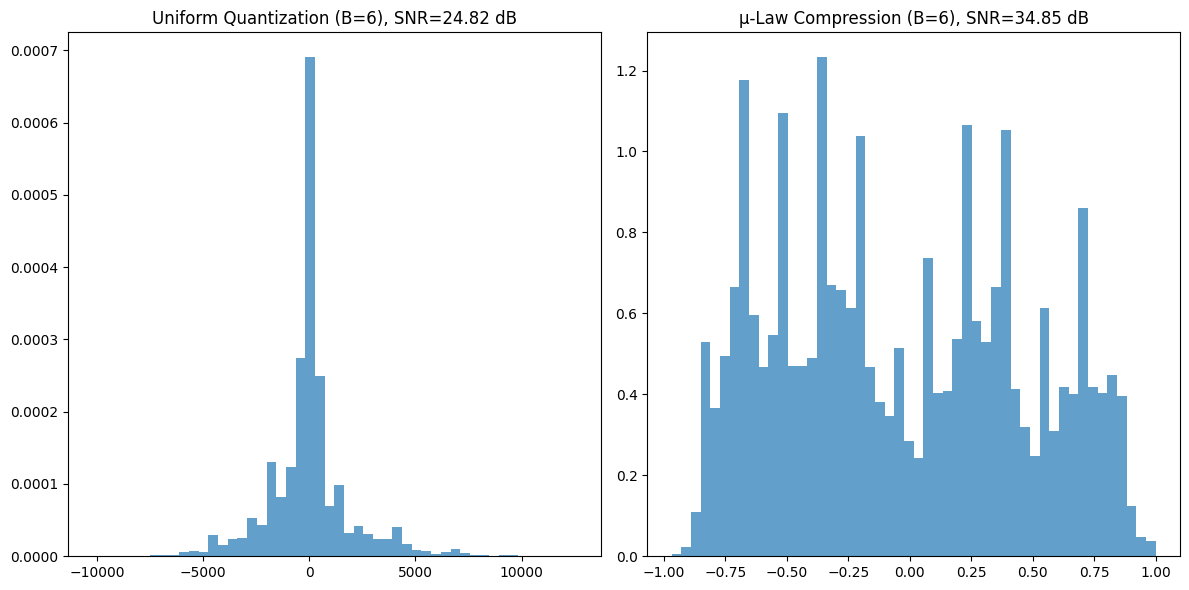

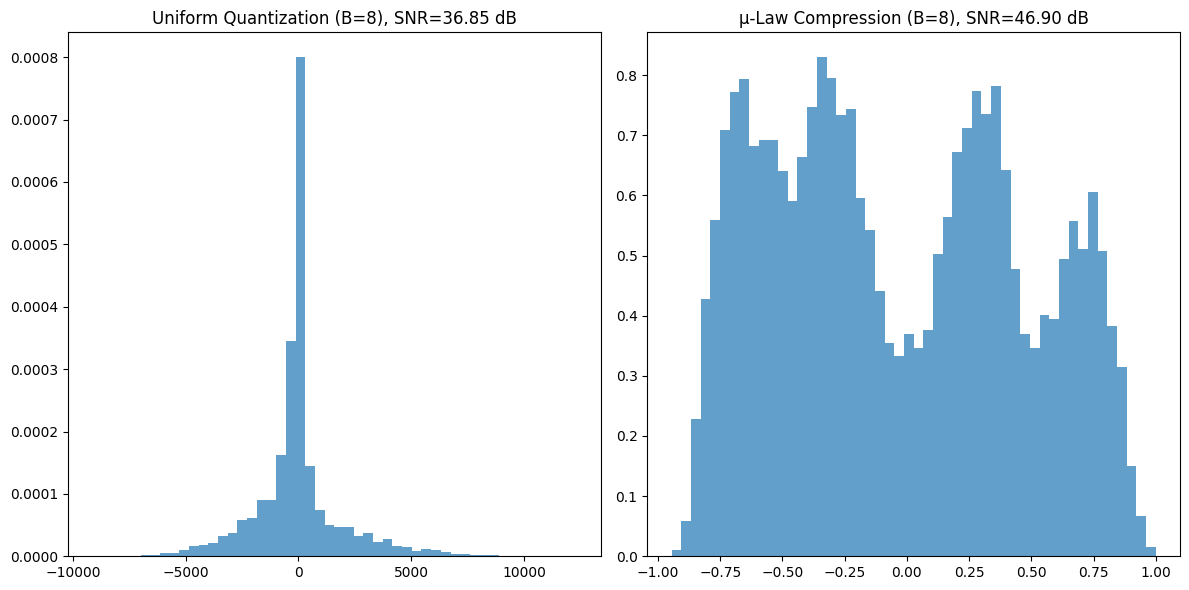

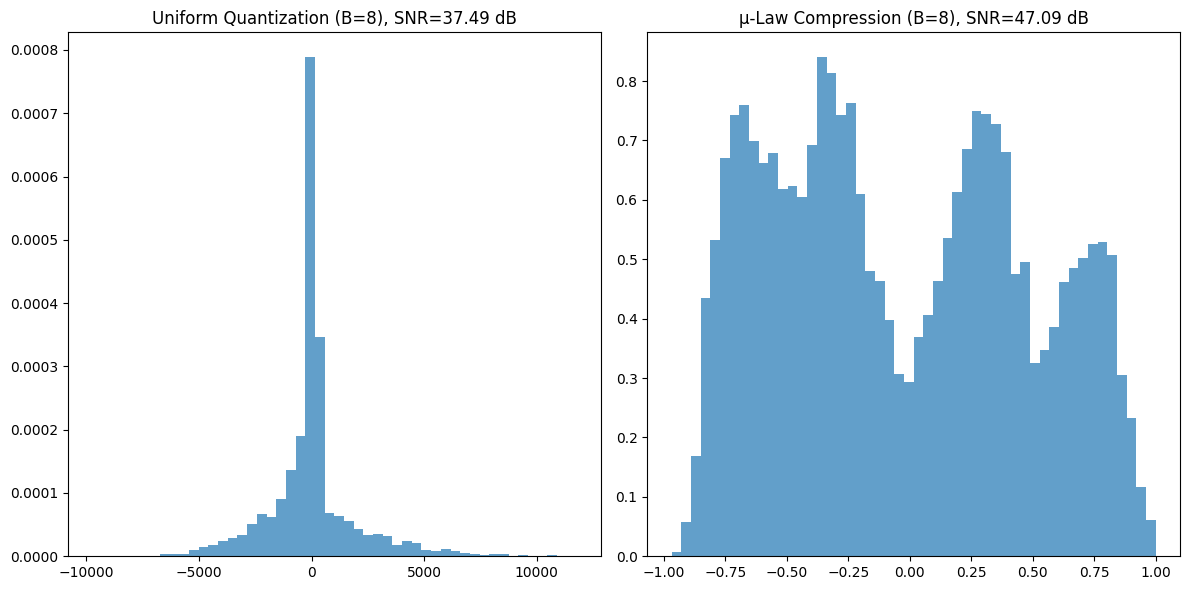

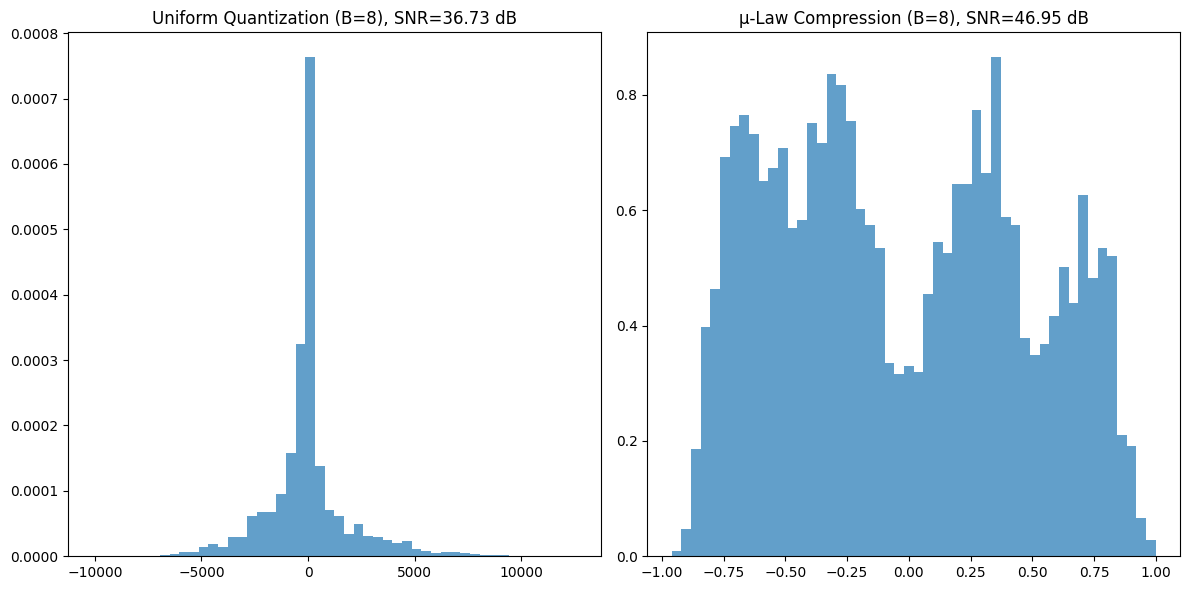

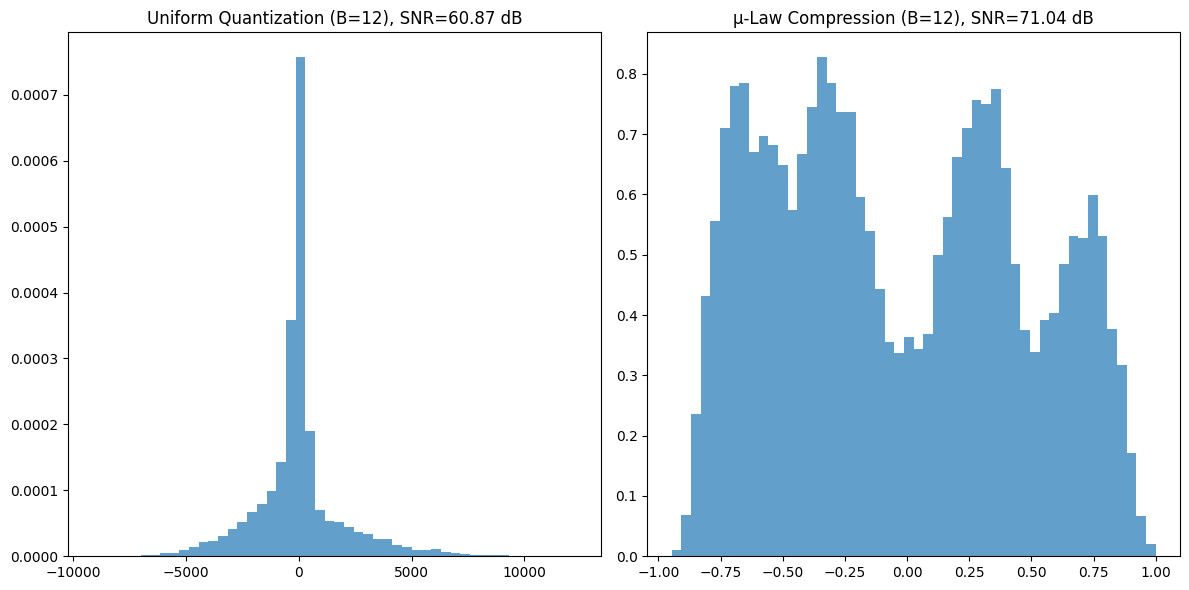

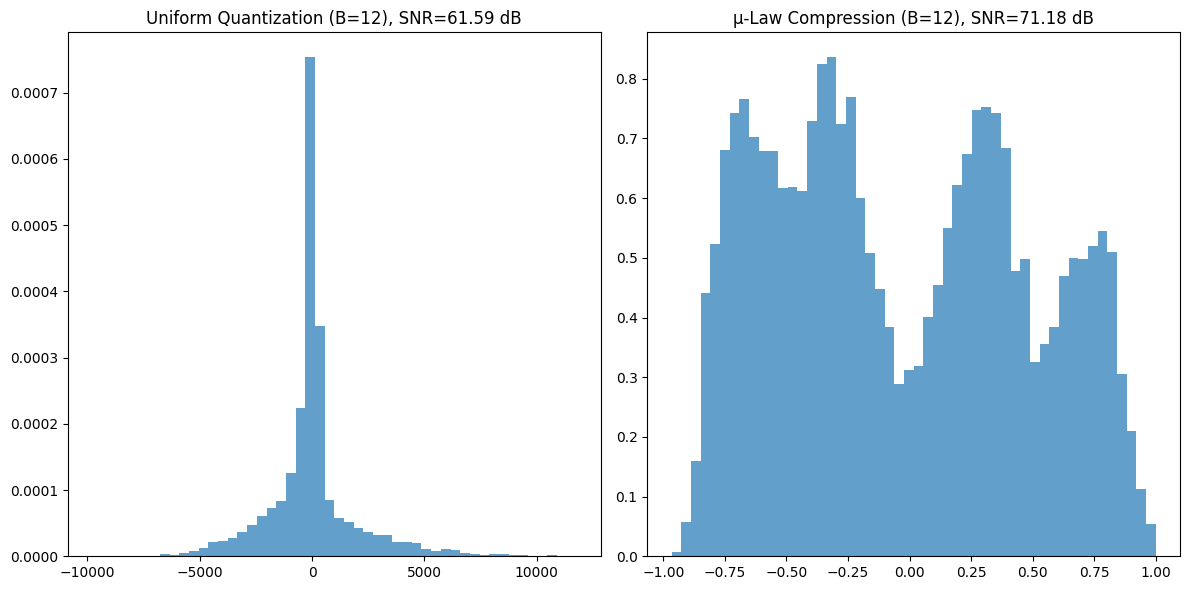

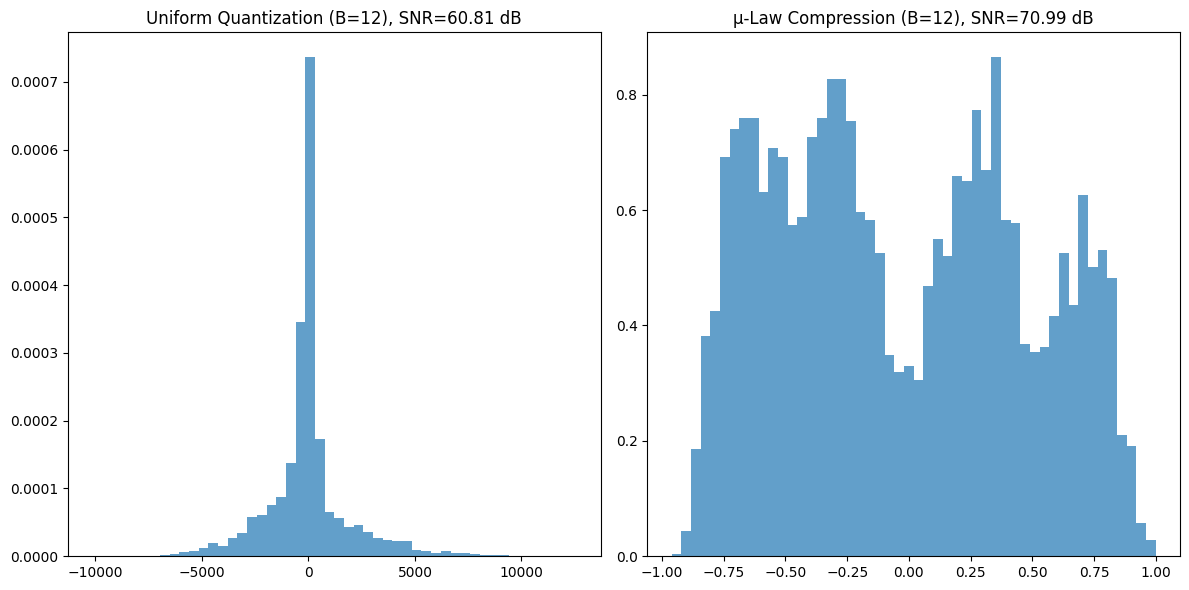

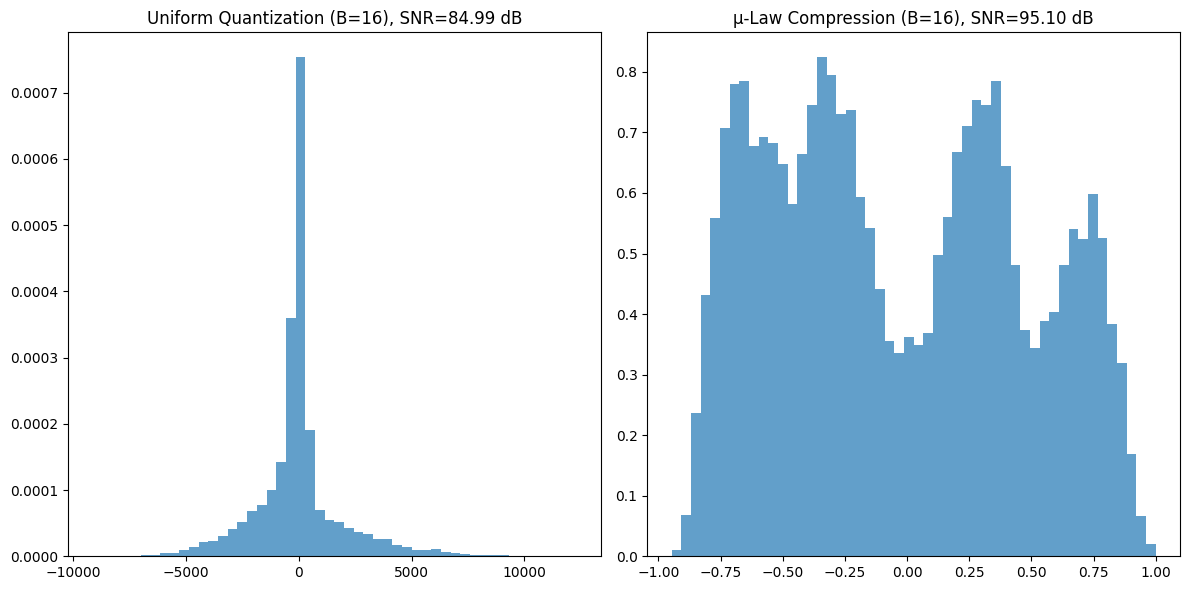

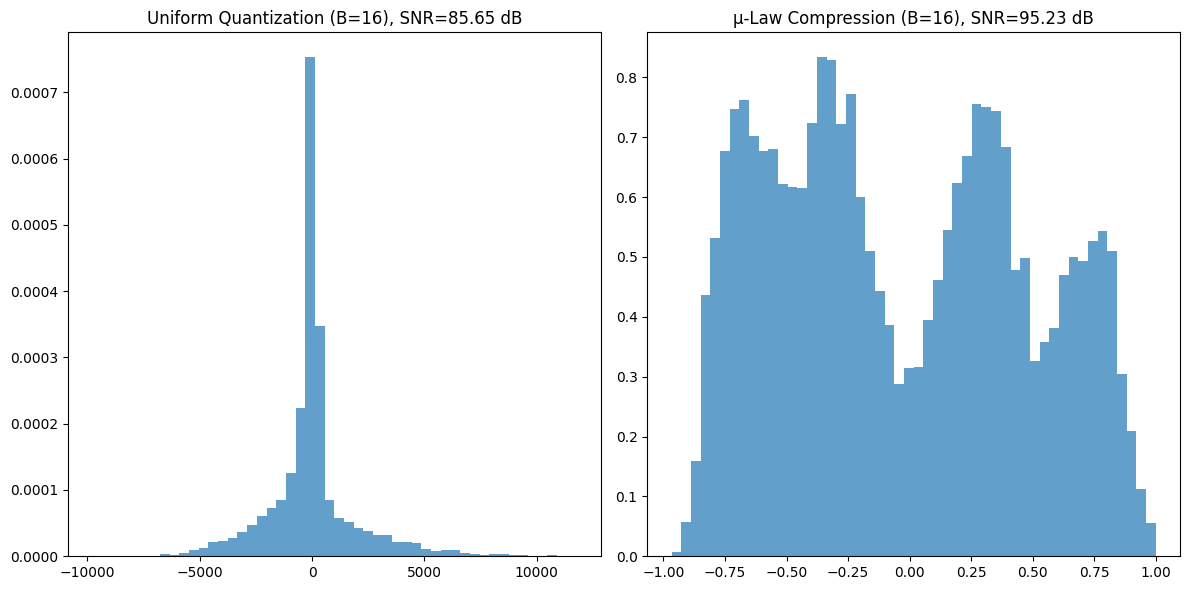

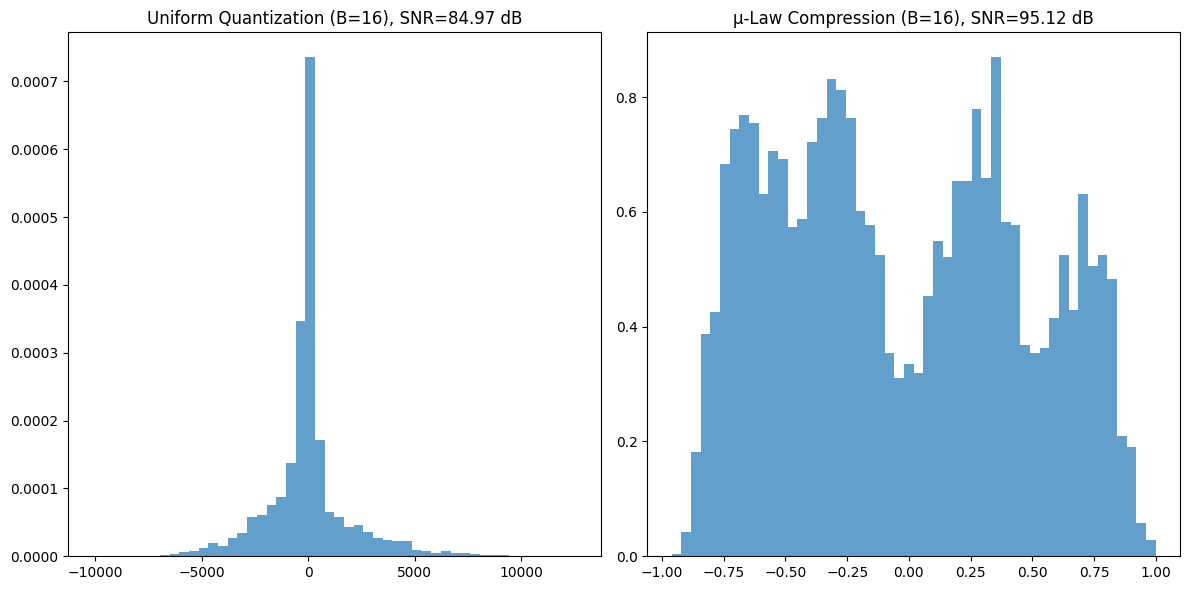

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to quantize the signal using uniform quantization
def uniform_quantization(signal, bits):
    max_value = np.max(np.abs(signal))
    quantization_levels = 2 ** bits
    step_size = 2 * max_value / quantization_levels
    quantized_signal = np.round(signal / step_size) * step_size
    return quantized_signal

# Function to quantize the signal using μ-Law compression
def mu_law_compression(signal, bits, mu=255):
    max_value = np.max(np.abs(signal))
    compressed_signal = np.sign(signal) * (np.log(1 + mu * np.abs(signal) / max_value) / np.log(1 + mu))
    quantized_signal = uniform_quantization(compressed_signal, bits)
    return quantized_signal
def mu_law_no_quant(signal,bits,mu=255):
    max_value = np.max(np.abs(signal))
    compressed_signal = np.sign(signal) * (np.log(1 + mu * np.abs(signal) / max_value) / np.log(1 + mu))
    return compressed_signal

# Function to calculate signal-to-noise ratio (SNR)
def calculate_snr(original_signal, quantized_signal):
    signal_power = np.sum(original_signal ** 2)
    error_signal = original_signal - quantized_signal
    error_power = np.sum(error_signal ** 2)
    snr = 10 * np.log10(signal_power / error_power)
    return snr

# Create a sample speech signal (you can replace this with your actual recorded signal)
sample_rate = len(signal1)  # Sample rate in Hz
duration = 1.0  # Duration of the signal in seconds
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
speech_signal =signal1  # Example sine wave as a placeholder

# Vary sampling rates
sampling_rates = [sample_rate, sample_rate // 2, sample_rate // 4]

# Vary quantization bits
quantization_bits = [3, 6, 8, 12, 16]

for bits in quantization_bits:
# bits=6
  for sr in sampling_rates:
      # Resample the signal
      resampled_signal = np.interp(np.linspace(0, duration, int(sr * duration)), t, speech_signal)

      # Uniform quantization
      uniform_quantized_signal = uniform_quantization(resampled_signal, bits)

      # μ-Law compression
      mu_law_quantized_signal = mu_law_compression(resampled_signal, bits)


      # Calculate SNR for both quantization methods
      snr_uniform = calculate_snr(resampled_signal, uniform_quantized_signal)
      snr_mu_law = calculate_snr(mu_law_no_quant(resampled_signal, bits), mu_law_quantized_signal)

      # Plot histograms of the quantized signals
      plt.figure(figsize=(12, 6))
      plt.subplot(1, 2, 1)
      plt.hist(uniform_quantized_signal, bins=50, density=True, alpha=0.7)
      plt.title(f'Uniform Quantization (B={bits}), SNR={snr_uniform:.2f} dB')

      plt.subplot(1, 2, 2)
      plt.hist(mu_law_quantized_signal, bins=50, density=True, alpha=0.7)
      plt.title(f'μ-Law Compression (B={bits}), SNR={snr_mu_law:.2f} dB')

      plt.tight_layout()
      plt.show()


### Member 2

<ipython-input-179-11c222bf2da8>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


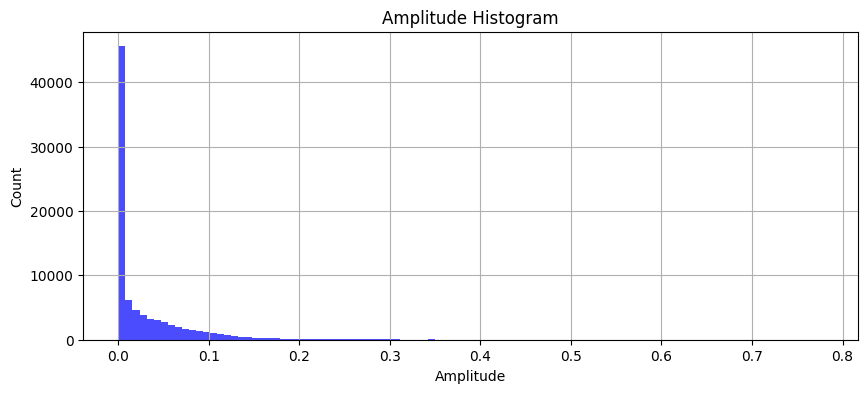

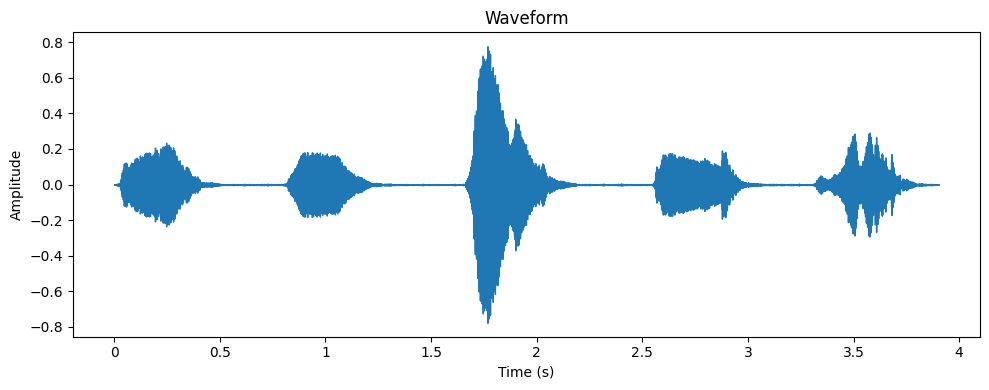

In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

def plot_amplitude_histogram(y, title):
    plt.figure(figsize=(10, 4))
    plt.hist(y, bins=100, color='blue', alpha=0.7)
    plt.xlabel('Amplitude')
    plt.ylabel('Count')
    plt.title(title)
    plt.grid()
    plt.show()

# Load the audio file
audio_path = '/content/audio_1.mp4'
y, sr = librosa.load(audio_path)

# Calculate amplitude
amplitudes = np.abs(y)

# Plot the histogram of amplitudes
plot_amplitude_histogram(amplitudes, 'Amplitude Histogram')

# Display the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.tight_layout()
plt.show()


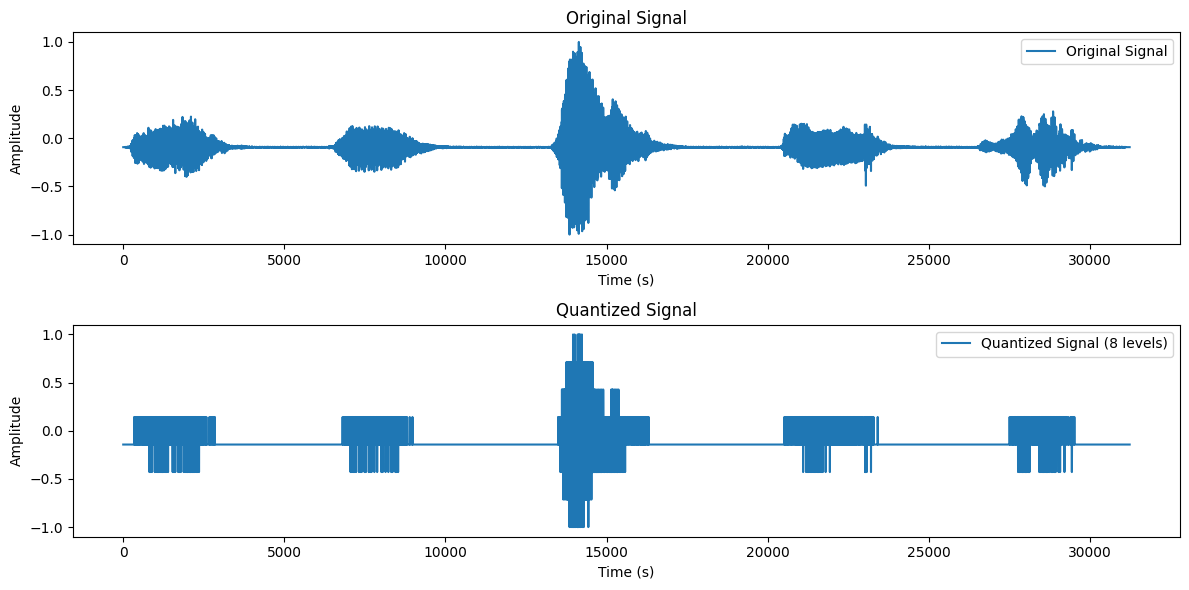

In [ ]:
# in place of x I need to put the given signal. -->> Uniform Quantiser
import numpy as np
import matplotlib.pyplot as plt

num_levels=8
# Generate the input signal (e.g., a sine wave)
duration = 1.0  # seconds
sampling_rate = 1000  # Hz
t = np.linspace(0, duration, int(duration * sampling_rate), endpoint=False)
x = signal1_1  # Example: sine wave
# Normalize the input signal to the range [-1, 1]
x_normalized = (x - np.min(x)) / (np.max(x) - np.min(x)) * 2 - 1

# Quantize the normalized signal
quantized_signal = np.round((x_normalized + 1) * (num_levels - 1) / 2) * 2 / (num_levels - 1) - 1

# Plot the original and quantized signals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot( x_normalized, label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot( quantized_signal, label=f'Quantized Signal ({num_levels} levels)')
plt.title('Quantized Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()


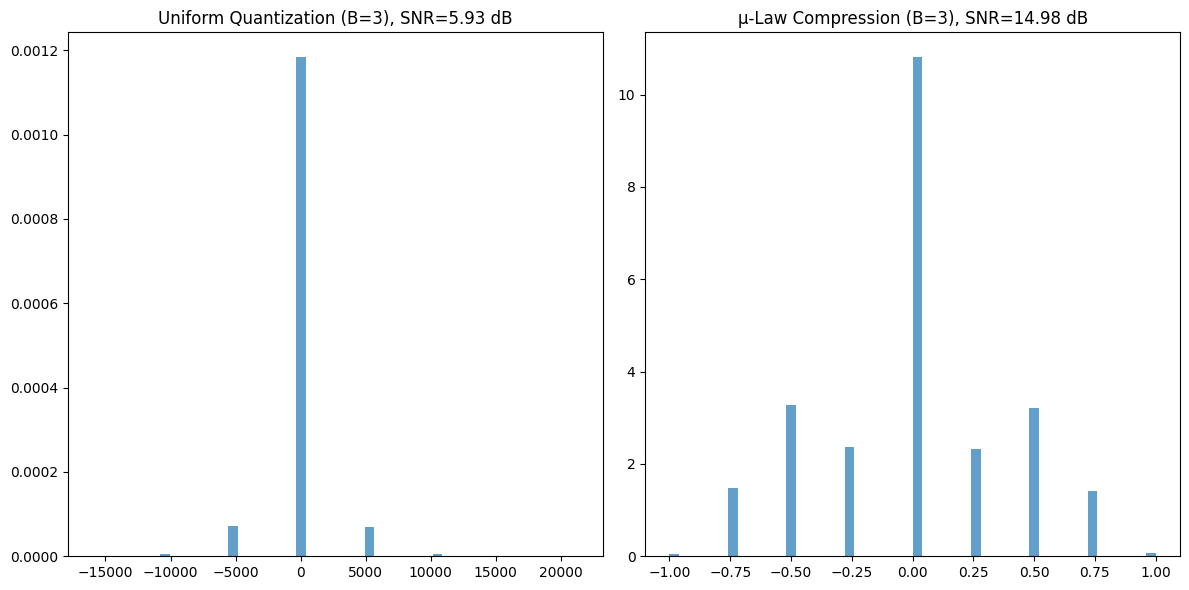

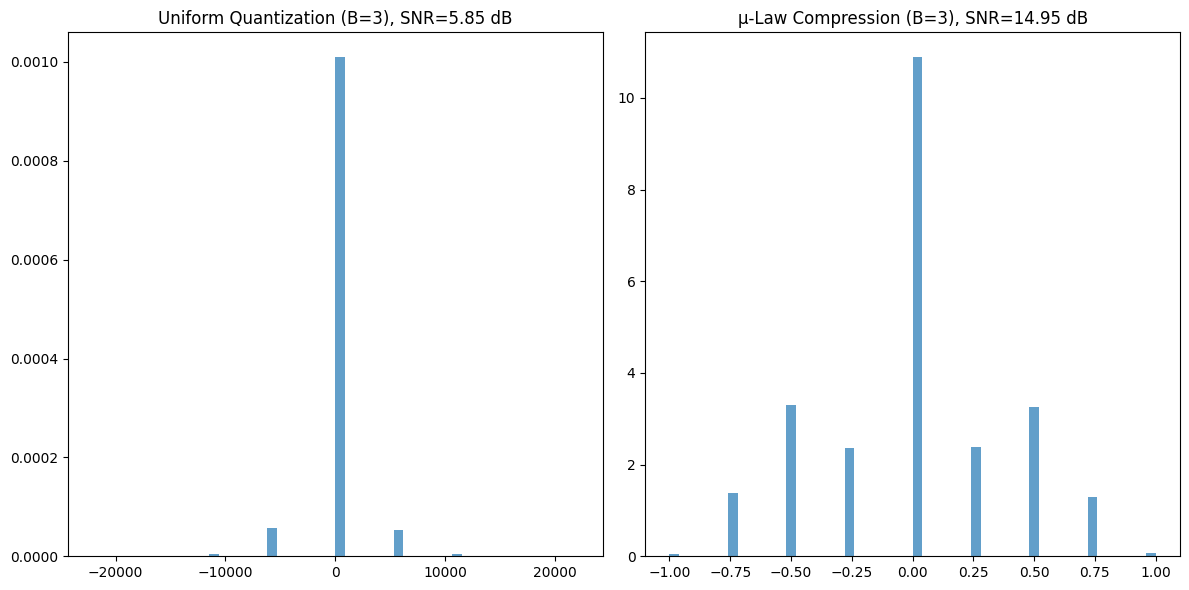

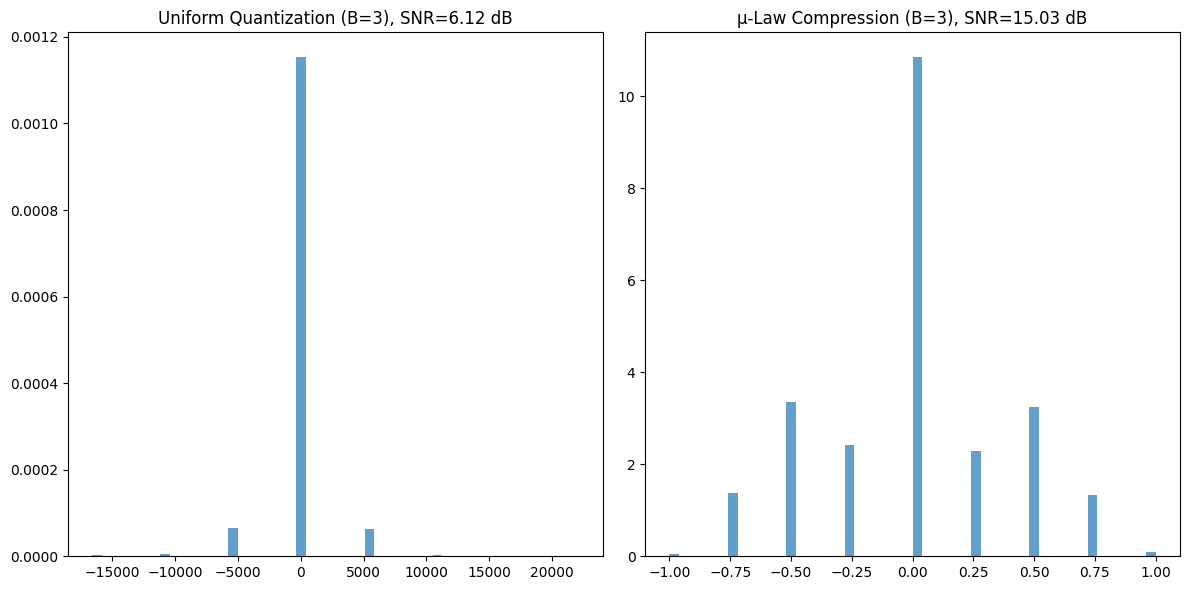

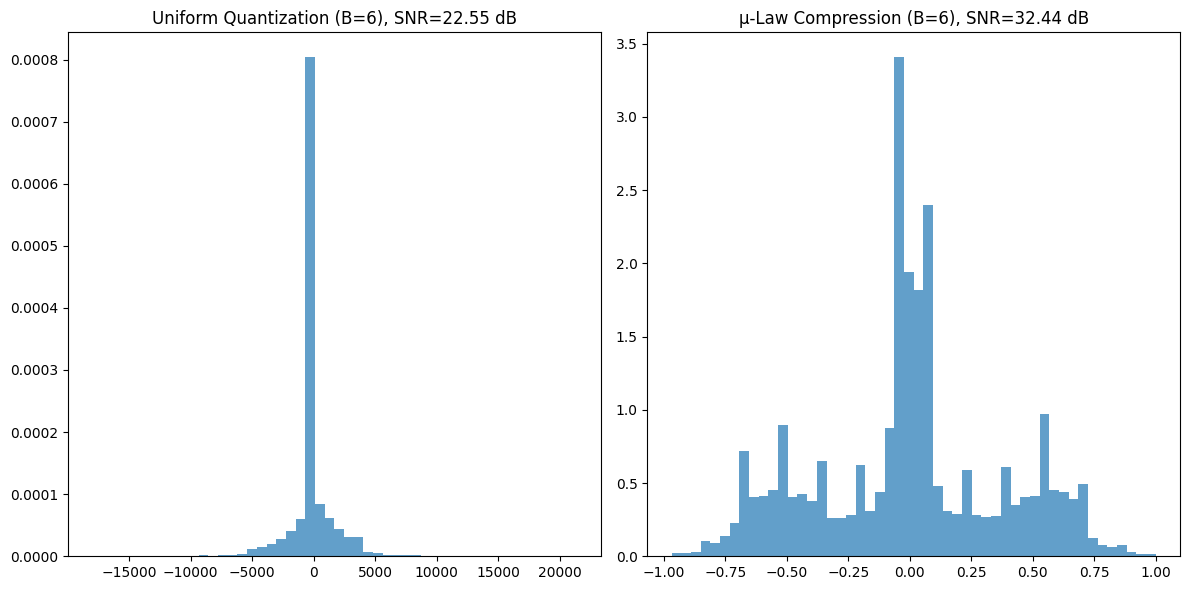

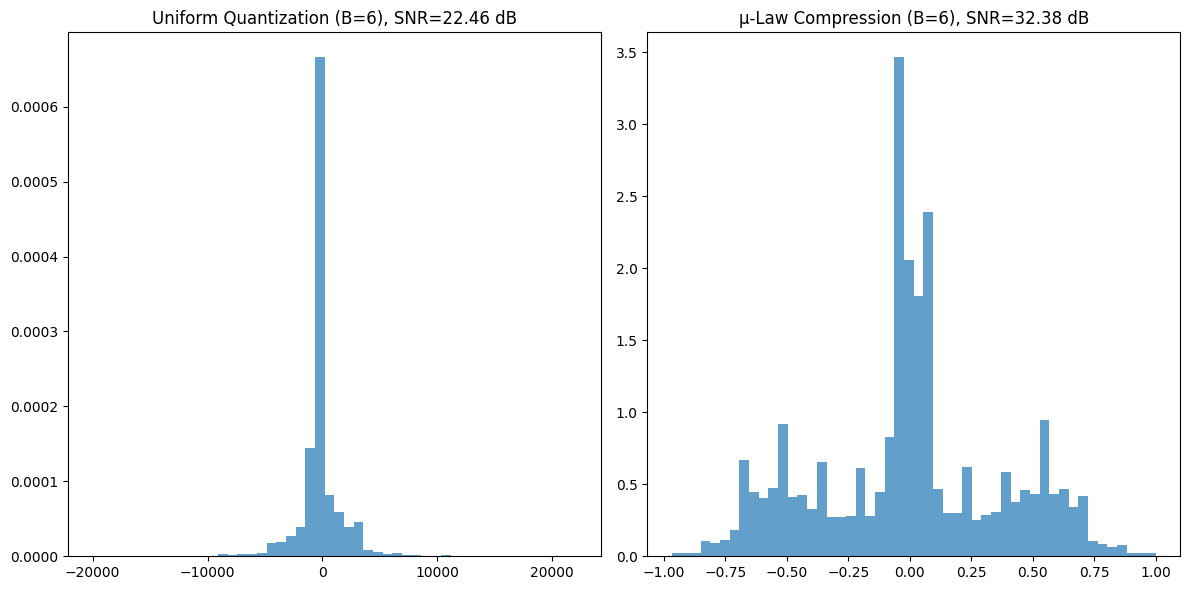

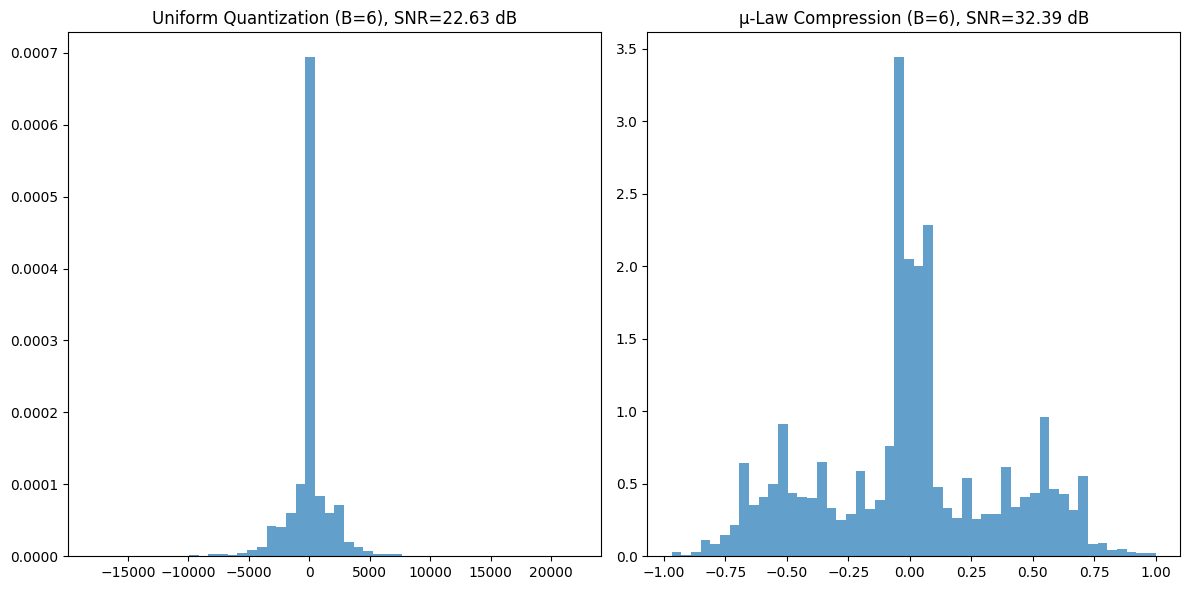

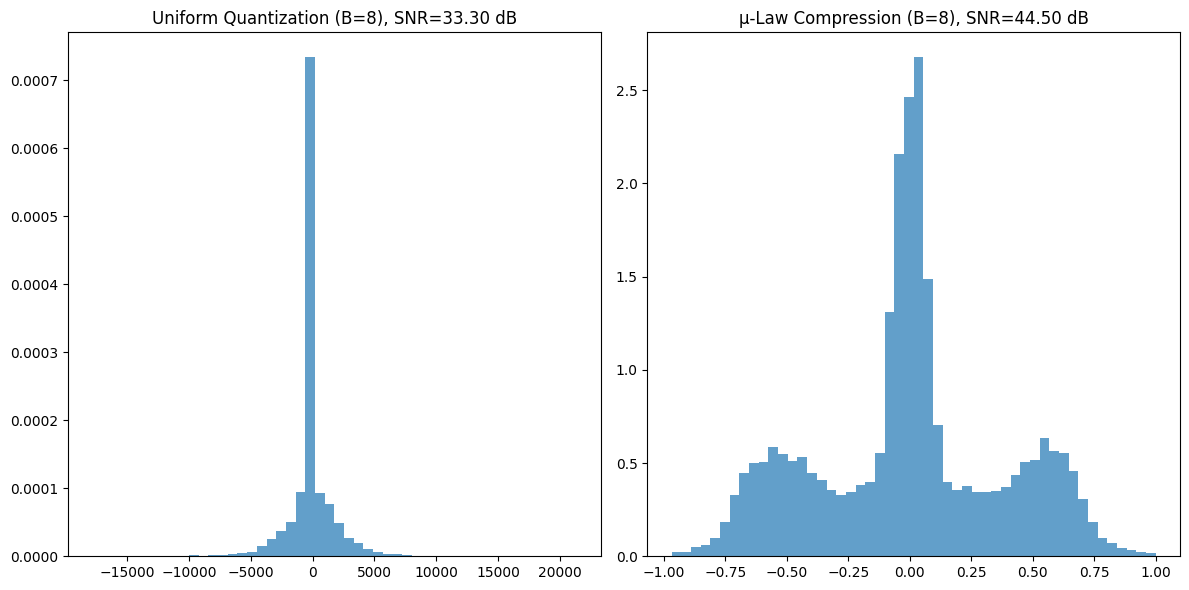

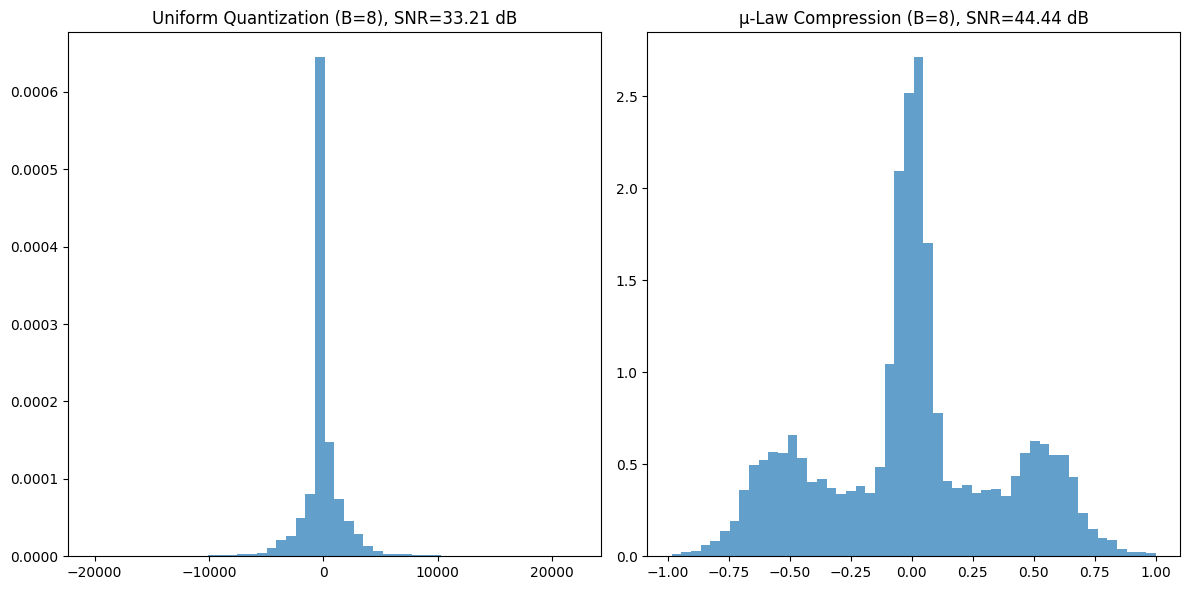

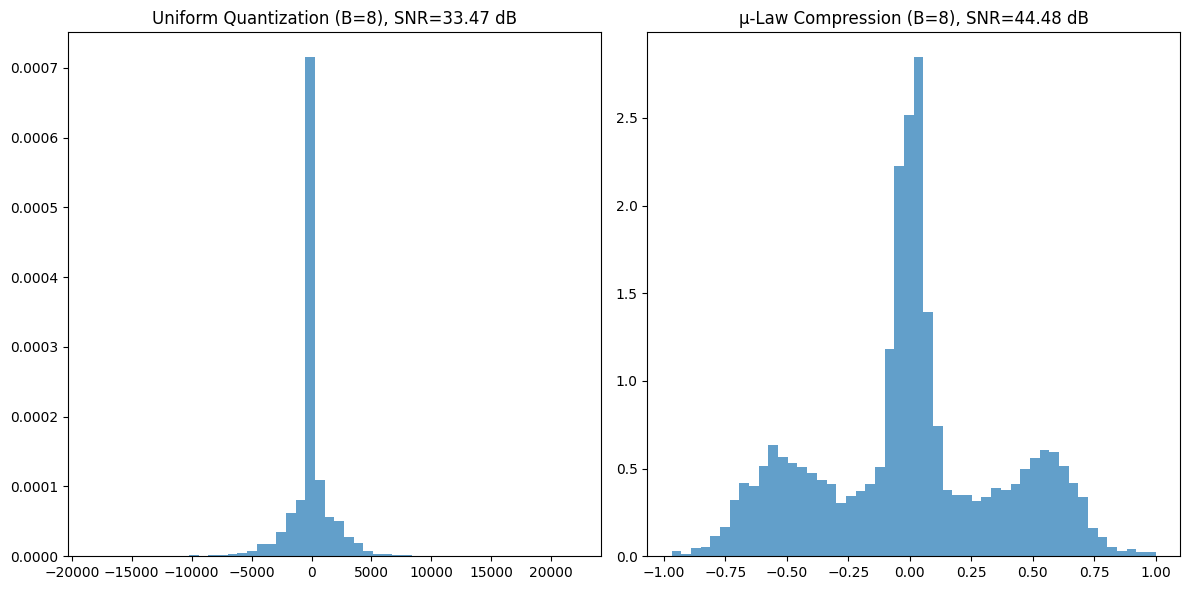

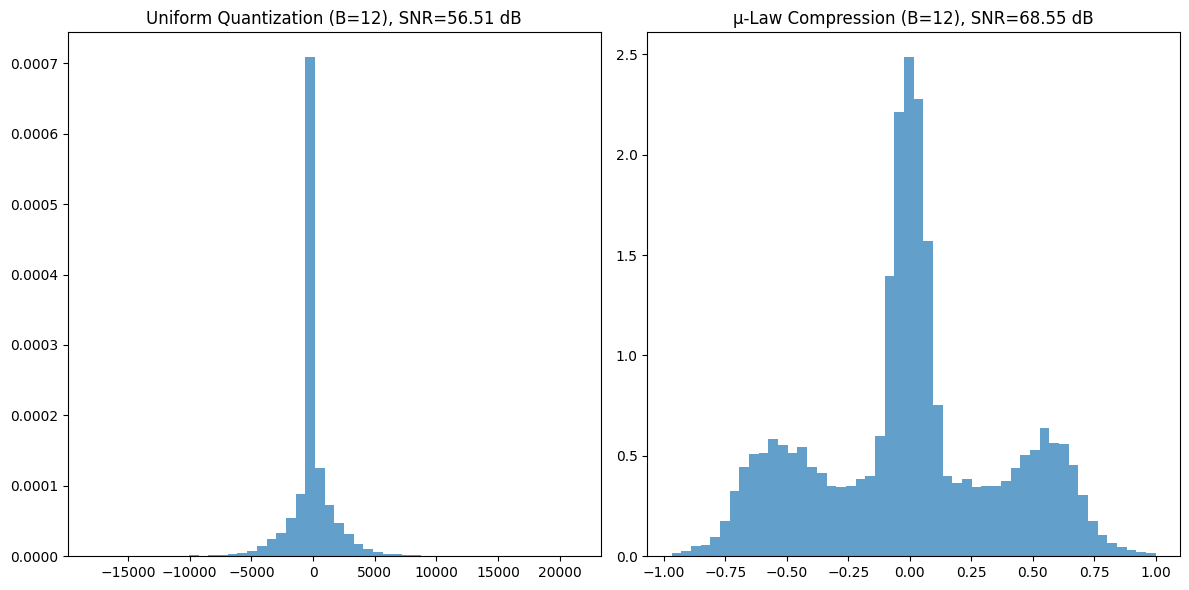

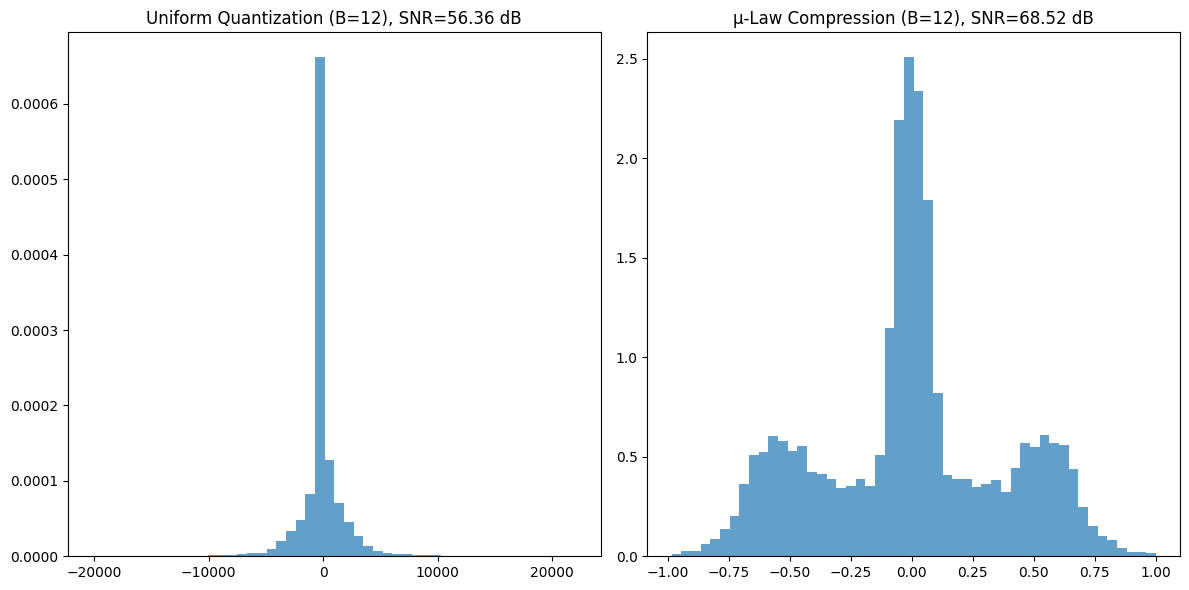

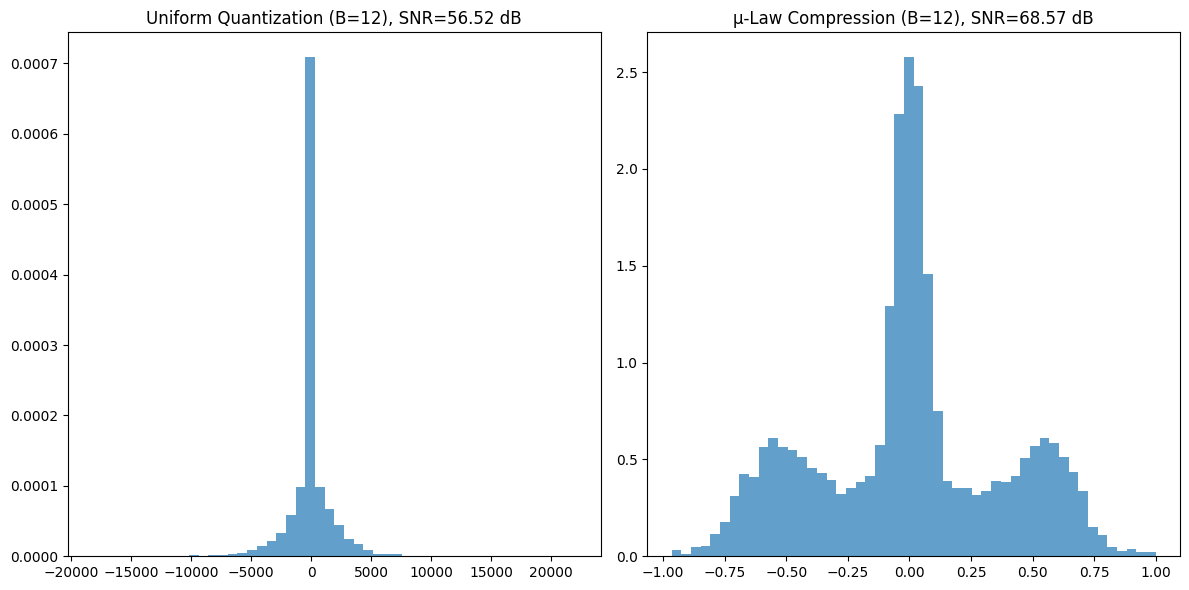

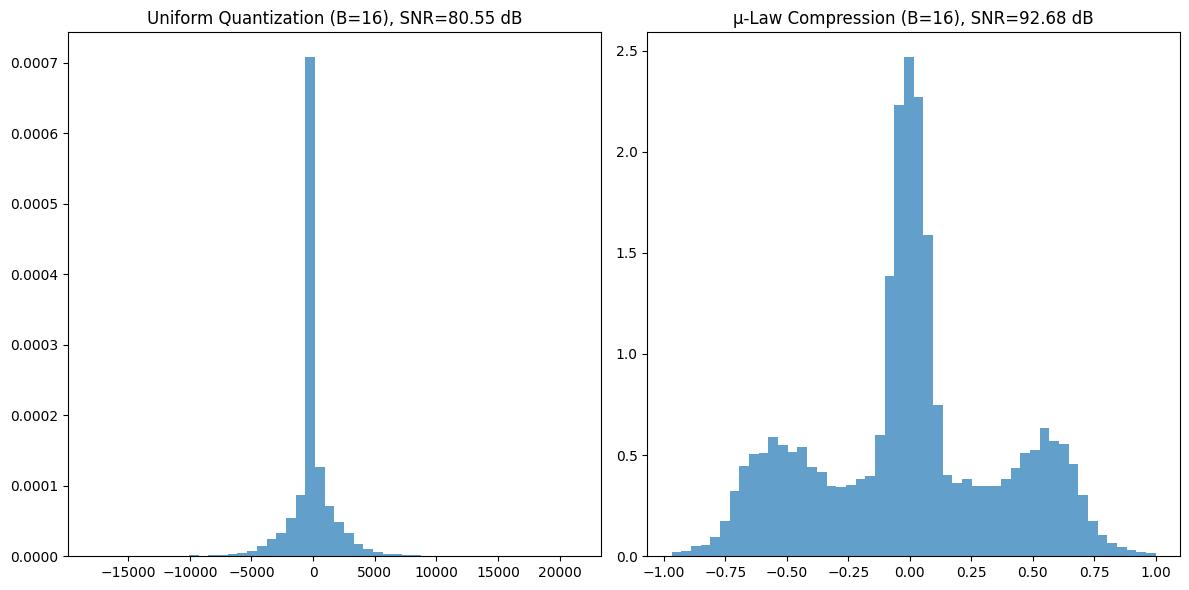

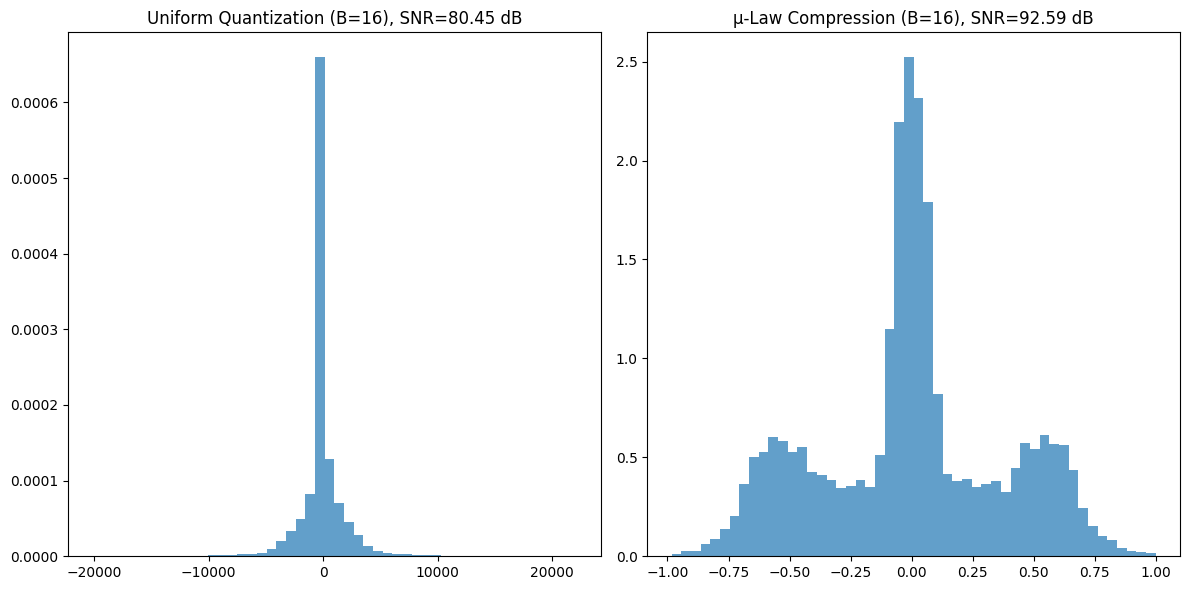

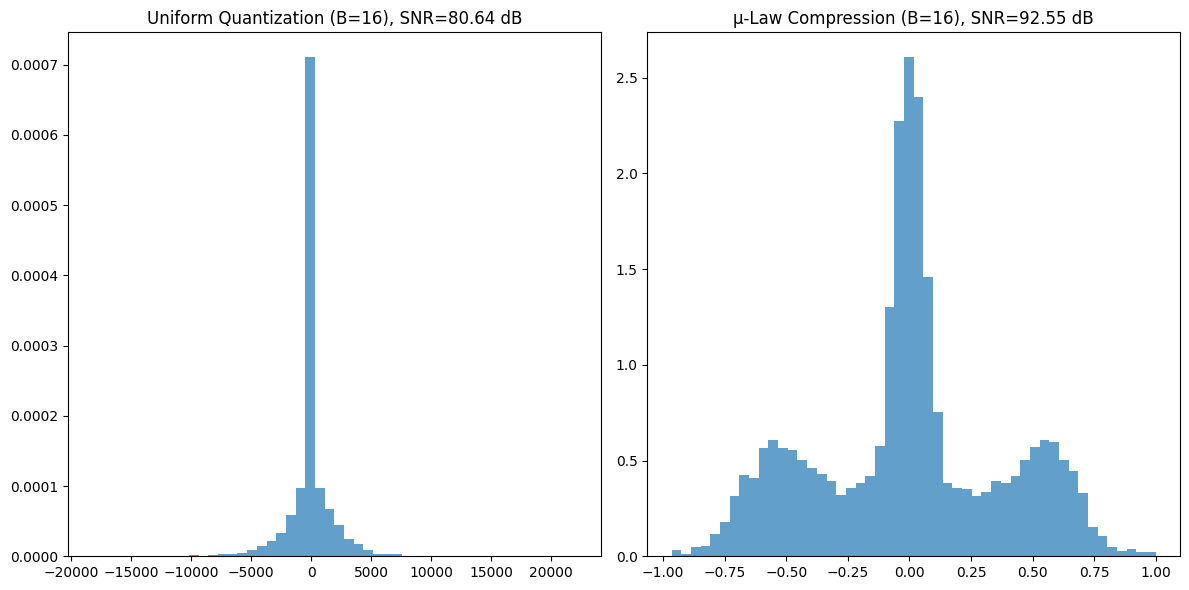

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to quantize the signal using uniform quantization
def uniform_quantization(signal, bits):
    max_value = np.max(np.abs(signal))
    quantization_levels = 2 ** bits
    step_size = 2 * max_value / quantization_levels
    quantized_signal = np.round(signal / step_size) * step_size
    return quantized_signal

# Function to quantize the signal using μ-Law compression
def mu_law_compression(signal, bits, mu=255):
    max_value = np.max(np.abs(signal))
    compressed_signal = np.sign(signal) * (np.log(1 + mu * np.abs(signal) / max_value) / np.log(1 + mu))
    quantized_signal = uniform_quantization(compressed_signal, bits)
    return quantized_signal
def mu_law_no_quant(signal,bits,mu=255):
    max_value = np.max(np.abs(signal))
    compressed_signal = np.sign(signal) * (np.log(1 + mu * np.abs(signal) / max_value) / np.log(1 + mu))
    return compressed_signal

# Function to calculate signal-to-noise ratio (SNR)
def calculate_snr(original_signal, quantized_signal):
    signal_power = np.sum(original_signal ** 2)
    error_signal = original_signal - quantized_signal
    error_power = np.sum(error_signal ** 2)
    snr = 10 * np.log10(signal_power / error_power)
    return snr

# Create a sample speech signal (you can replace this with your actual recorded signal)
sample_rate = len(signal1_1)  # Sample rate in Hz
duration = 1.0  # Duration of the signal in seconds
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
speech_signal =signal1_1  # Example sine wave as a placeholder

# Vary sampling rates
sampling_rates = [sample_rate, sample_rate // 2, sample_rate // 4]

# Vary quantization bits
quantization_bits = [3, 6, 8, 12, 16]

for bits in quantization_bits:
# bits=6
  for sr in sampling_rates:
      # Resample the signal
      resampled_signal = np.interp(np.linspace(0, duration, int(sr * duration)), t, speech_signal)

      # Uniform quantization
      uniform_quantized_signal = uniform_quantization(resampled_signal, bits)

      # μ-Law compression
      mu_law_quantized_signal = mu_law_compression(resampled_signal, bits)


      # Calculate SNR for both quantization methods
      snr_uniform = calculate_snr(resampled_signal, uniform_quantized_signal)
      snr_mu_law = calculate_snr(mu_law_no_quant(resampled_signal, bits), mu_law_quantized_signal)

      # Plot histograms of the quantized signals
      plt.figure(figsize=(12, 6))
      plt.subplot(1, 2, 1)
      plt.hist(uniform_quantized_signal, bins=50, density=True, alpha=0.7)
      plt.title(f'Uniform Quantization (B={bits}), SNR={snr_uniform:.2f} dB')

      plt.subplot(1, 2, 2)
      plt.hist(mu_law_quantized_signal, bins=50, density=True, alpha=0.7)
      plt.title(f'μ-Law Compression (B={bits}), SNR={snr_mu_law:.2f} dB')

      plt.tight_layout()
      plt.show()


# Question 4

<ipython-input-174-85ab83086caa>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  y1, sr1 = librosa.load(audio_path1)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


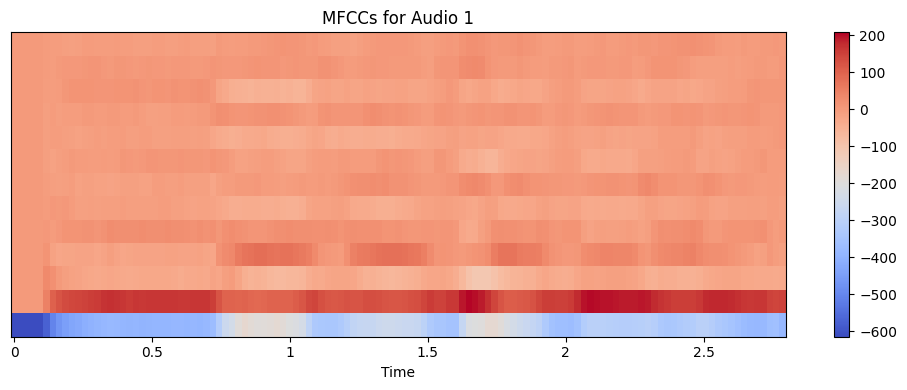

<ipython-input-174-85ab83086caa>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y2, sr2 = librosa.load(audio_path2)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


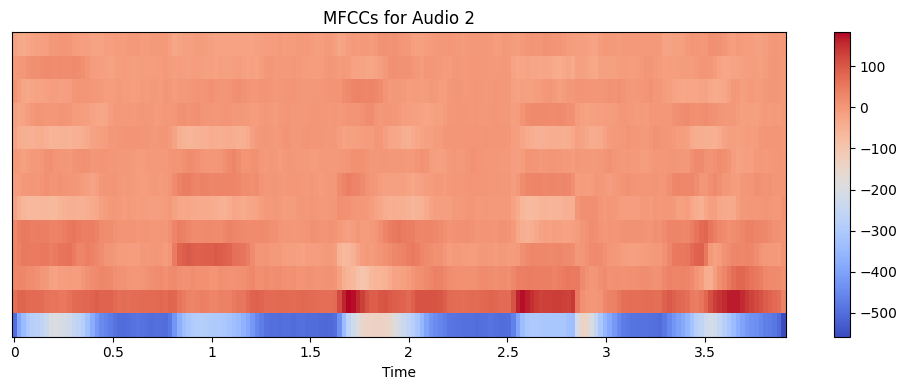

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_mfcc(mfccs, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Load the first audio file
audio_path1 = '/content/audio.mp4'
y1, sr1 = librosa.load(audio_path1)
mfccs1 = librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=13)
plot_mfcc(mfccs1, 'MFCCs for Audio 1')

# Load the second audio file
audio_path2 = '/content/audio_1.mp4'
y2, sr2 = librosa.load(audio_path2)
mfccs2 = librosa.feature.mfcc(y=y2, sr=sr2, n_mfcc=13)
plot_mfcc(mfccs2, 'MFCCs for Audio 2')

### MFCC Component1

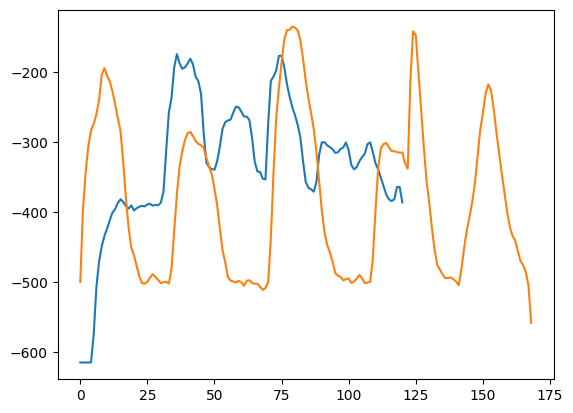

In [ ]:
plt.plot(mfccs1[0])
plt.plot(mfccs2[0])


### MFCC Component2

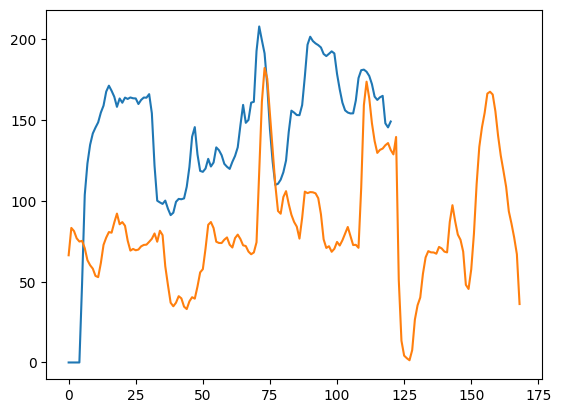

In [ ]:
plt.plot(mfccs1[1])
plt.plot(mfccs2[1])

### MFCC Component3

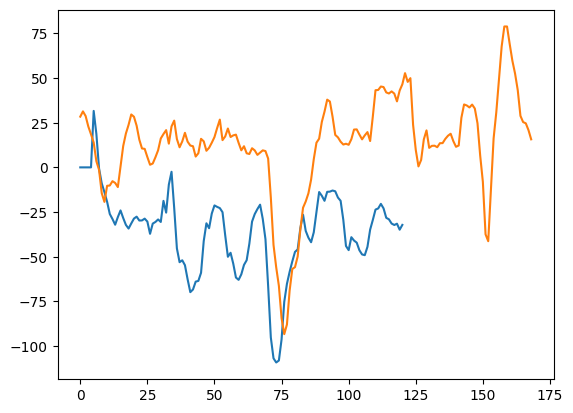

In [ ]:
plt.plot(mfccs1[2])
plt.plot(mfccs2[2])